In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.ESN_v3_AR import ESN as AR_RNN_ESN
from tools.AEESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-23 19:20:28.342202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 19:20:28.342563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 19:20:28.381307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 19:20:28.381669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 19:20:28.381976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_027'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ESN/ESN_027
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

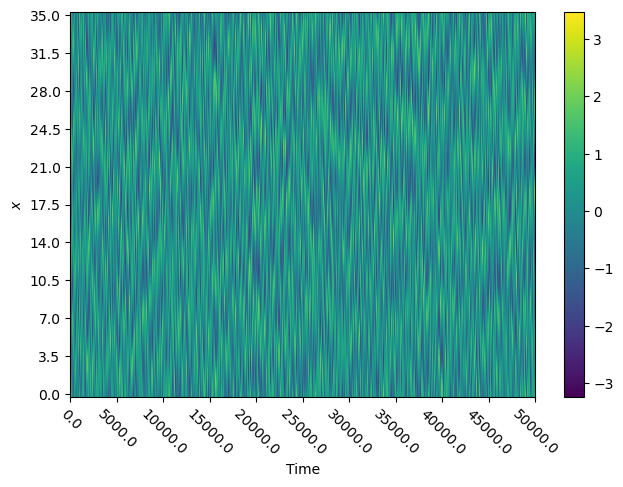

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

In [16]:
all_data.shape

(500026, 64)

# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    train_alpha = [False]
    train_omega_in = [False]
    train_rho_res = [False]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None
ListWrapper([False])
ListWrapper([False])
ListWrapper([False])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0261 - mse: 6.6566e-04 - NMSE: 0.0060 - covmat_fro_loss: 2.8917e-04 - global_gradnorm: 0.7133 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 0m 14.6s

Epoch 1: val_NMSE improved from inf to 0.00605, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/chec

Epoch 9/1000
76/76 [==============================] - ETA: 0s - loss: 0.0254 - mse: 5.9284e-04 - NMSE: 0.0053 - covmat_fro_loss: 2.7522e-04 - global_gradnorm: 0.6580 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 1m 19.9s

Epoch 9: val_NMSE improved from 0.00564 to 0.00551, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0254 - mse: 5.9284e-04 - NMSE: 0.0053 - covmat_fro_loss: 2.7514e-04 - global_gradnorm: 0.6569 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0256 - val_mse: 6.1211e-04 - val_NMSE: 0.0055 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 10/1000


Epoch 18/1000
76/76 [==============================] - ETA: 0s - loss: 0.0251 - mse: 5.5645e-04 - NMSE: 0.0050 - covmat_fro_loss: 2.6804e-04 - global_gradnorm: 0.6260 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 32.8s

Epoch 18: val_NMSE improved from 0.00534 to 0.00528, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0251 - mse: 5.5645e-04 - NMSE: 0.0050 - covmat_fro_loss: 2.6815e-04 - global_gradnorm: 0.6250 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0253 - val_mse: 5.8662e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 19/100

Epoch 27/1000
76/76 [==============================] - ETA: 0s - loss: 0.0248 - mse: 5.3321e-04 - NMSE: 0.0048 - covmat_fro_loss: 2.6324e-04 - global_gradnorm: 0.6040 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 3m 45.8s

Epoch 27: val_NMSE improved from 0.00517 to 0.00510, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0248 - mse: 5.3321e-04 - NMSE: 0.0048 - covmat_fro_loss: 2.6302e-04 - global_gradnorm: 0.6035 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 5.6685e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 28/100

76/76 [==============================] - ETA: 0s - loss: 0.0246 - mse: 5.1431e-04 - NMSE: 0.0046 - covmat_fro_loss: 2.5945e-04 - global_gradnorm: 0.5804 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 4m 58.7s

Epoch 36: val_NMSE did not improve from 0.00502
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0246 - mse: 5.1431e-04 - NMSE: 0.0046 - covmat_fro_loss: 2.5938e-04 - global_gradnorm: 0.5797 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 5.5895e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 37/1000
76/76 [==============================] - ETA: 0s - loss: 0.0246 - mse: 5.1338e-04 - NMSE: 0.0046 - covmat_fro_loss: 2.5933e-04 - global_gr

Epoch 45/1000
76/76 [==============================] - ETA: 0s - loss: 0.0244 - mse: 4.9849e-04 - NMSE: 0.0045 - covmat_fro_loss: 2.5603e-04 - global_gradnorm: 0.5745 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 6m 11.7s

Epoch 45: val_NMSE improved from 0.00488 to 0.00485, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0244 - mse: 4.9849e-04 - NMSE: 0.0045 - covmat_fro_loss: 2.5597e-04 - global_gradnorm: 0.5748 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0247 - val_mse: 5.3895e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 46/100

76/76 [==============================] - ETA: 0s - loss: 0.0242 - mse: 4.8785e-04 - NMSE: 0.0044 - covmat_fro_loss: 2.5362e-04 - global_gradnorm: 0.5711 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 7m 24.4s

Epoch 54: val_NMSE did not improve from 0.00478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0242 - mse: 4.8785e-04 - NMSE: 0.0044 - covmat_fro_loss: 2.5353e-04 - global_gradnorm: 0.5705 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0246 - val_mse: 5.3161e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 55/1000
76/76 [==============================] - ETA: 0s - loss: 0.0242 - mse: 4.8561e-04 - NMSE: 0.0044 - covmat_fro_loss: 2.5343e-04 - global_gr

Epoch 63/1000
76/76 [==============================] - ETA: 0s - loss: 0.0240 - mse: 4.7337e-04 - NMSE: 0.0043 - covmat_fro_loss: 2.5046e-04 - global_gradnorm: 0.5504 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 8m 37.5s

Epoch 63: val_NMSE did not improve from 0.00468
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0240 - mse: 4.7337e-04 - NMSE: 0.0043 - covmat_fro_loss: 2.5063e-04 - global_gradnorm: 0.5519 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0245 - val_mse: 5.2589e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 64/1000
76/76 [==============================] - ETA: 0s - loss: 0.0240 - mse: 4.7249e-04 - NMSE: 0.0043 - covmat_fro_loss: 2.5025e-

76/76 [==============================] - ETA: 0s - loss: 0.0238 - mse: 4.6062e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.4759e-04 - global_gradnorm: 0.5331 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 9m 50.1s

Epoch 72: val_NMSE did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0238 - mse: 4.6062e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.4749e-04 - global_gradnorm: 0.5337 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0243 - val_mse: 5.1493e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 73/1000
76/76 [==============================] - ETA: 0s - loss: 0.0238 - mse: 4.6126e-04 - NMSE: 0.0042 - covmat_fro_loss: 2.4740e-04 - global_gr

Epoch 82/1000
76/76 [==============================] - ETA: 0s - loss: 0.0237 - mse: 4.4981e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4509e-04 - global_gradnorm: 0.5237 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 11m 11.1s

Epoch 82: val_NMSE did not improve from 0.00449
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0237 - mse: 4.4981e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4525e-04 - global_gradnorm: 0.5230 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0241 - val_mse: 5.0134e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0237 - mse: 4.4951e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4502e

76/76 [==============================] - ETA: 0s - loss: 0.0235 - mse: 4.4220e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4359e-04 - global_gradnorm: 0.5170 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 12m 23.7s

Epoch 91: val_NMSE did not improve from 0.00444
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0235 - mse: 4.4220e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4394e-04 - global_gradnorm: 0.5173 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0240 - val_mse: 4.9411e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 92/1000
76/76 [==============================] - ETA: 0s - loss: 0.0235 - mse: 4.4054e-04 - NMSE: 0.0040 - covmat_fro_loss: 2.4300e-04 - global_g

Epoch 100/1000
76/76 [==============================] - ETA: 0s - loss: 0.0234 - mse: 4.3314e-04 - NMSE: 0.0039 - covmat_fro_loss: 2.4121e-04 - global_gradnorm: 0.5066 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 36.5s

Epoch 100: val_NMSE improved from 0.00436 to 0.00432, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0234 - mse: 4.3314e-04 - NMSE: 0.0039 - covmat_fro_loss: 2.4124e-04 - global_gradnorm: 0.5076 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0238 - val_mse: 4.8045e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 101

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0232 - mse: 4.2363e-04 - NMSE: 0.0038 - covmat_fro_loss: 2.3846e-04 - global_gradnorm: 0.4968 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0237 - val_mse: 4.7727e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 110/1000
76/76 [==============================] - ETA: 0s - loss: 0.0232 - mse: 4.2390e-04 - NMSE: 0.0038 - covmat_fro_loss: 2.3909e-04 - global_gradnorm: 0.5023 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 14m 56.6s

Epoch 110: val_NMSE improved from 0.00430 to 0.00427, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 119/1000
76/76 [==============================] - ETA: 0s - loss: 0.0231 - mse: 4.1519e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3698e-04 - global_gradnorm: 0.4907 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 16m 9.2s

Epoch 119: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0231 - mse: 4.1519e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3701e-04 - global_gradnorm: 0.4908 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0235 - val_mse: 4.7103e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 120/1000
76/76 [==============================] - ETA: 0s - loss: 0.0230 - mse: 4.1314e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.363

76/76 [==============================] - ETA: 0s - loss: 0.0229 - mse: 4.0885e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3523e-04 - global_gradnorm: 0.4854 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 17m 21.2s

Epoch 128: val_NMSE improved from 0.00417 to 0.00414, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0229 - mse: 4.0885e-04 - NMSE: 0.0037 - covmat_fro_loss: 2.3535e-04 - global_gradnorm: 0.4854 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0234 - val_mse: 4.6036e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 129/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0228 - mse: 4.0171e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3342e-04 - global_gradnorm: 0.4742 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 18m 33.6s

Epoch 137: val_NMSE improved from 0.00411 to 0.00411, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0228 - mse: 4.0171e-04 - NMSE: 0.0036 - covmat_fro_loss: 2.3351e-04 - global_gradnorm: 0.4746 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0233 - val_mse: 4.5634e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 138/1000
76/76 [==

Epoch 146/1000
76/76 [==============================] - ETA: 0s - loss: 0.0227 - mse: 3.9405e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3143e-04 - global_gradnorm: 0.4675 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 19m 46.6s

Epoch 146: val_NMSE did not improve from 0.00406
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0227 - mse: 3.9405e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3161e-04 - global_gradnorm: 0.4687 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0232 - val_mse: 4.5642e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 147/1000
76/76 [==============================] - ETA: 0s - loss: 0.0226 - mse: 3.9423e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.31

76/76 [==============================] - ETA: 0s - loss: 0.0225 - mse: 3.8846e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3009e-04 - global_gradnorm: 0.4686 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 20m 59.3s

Epoch 155: val_NMSE did not improve from 0.00400
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 104ms/step - loss: 0.0225 - mse: 3.8846e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3020e-04 - global_gradnorm: 0.4701 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0230 - val_mse: 4.4681e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 156/1000
76/76 [==============================] - ETA: 0s - loss: 0.0225 - mse: 3.8676e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.2970e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0224 - mse: 3.8237e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2862e-04 - global_gradnorm: 0.4528 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 22m 11.2s

Epoch 164: val_NMSE improved from 0.00398 to 0.00393, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0224 - mse: 3.8237e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2834e-04 - global_gradnorm: 0.4515 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0229 - val_mse: 4.3668e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 165/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0223 - mse: 3.7661e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2687e-04 - global_gradnorm: 0.4579 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 23m 23.8s

Epoch 173: val_NMSE did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0223 - mse: 3.7661e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2691e-04 - global_gradnorm: 0.4580 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0228 - val_mse: 4.4100e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 174/1000
76/76 [==============================] - ETA: 0s - loss: 0.0223 - mse: 3.7780e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.2730e-04 - global

Epoch 183/1000
76/76 [==============================] - ETA: 0s - loss: 0.0221 - mse: 3.7166e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2575e-04 - global_gradnorm: 0.4409 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 24m 44.2s

Epoch 183: val_NMSE did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0221 - mse: 3.7166e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2553e-04 - global_gradnorm: 0.4411 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0226 - val_mse: 4.3123e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 184/1000
76/76 [==============================] - ETA: 0s - loss: 0.0221 - mse: 3.7184e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.25

76/76 [==============================] - ETA: 0s - loss: 0.0220 - mse: 3.6942e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2514e-04 - global_gradnorm: 0.4597 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 25m 57.6s

Epoch 192: val_NMSE did not improve from 0.00380
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0220 - mse: 3.6942e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2519e-04 - global_gradnorm: 0.4600 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0225 - val_mse: 4.2286e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 193/1000
76/76 [==============================] - ETA: 0s - loss: 0.0220 - mse: 3.6442e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2369e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0219 - mse: 3.6308e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2326e-04 - global_gradnorm: 0.4489 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 27m 11.7s

Epoch 201: val_NMSE improved from 0.00378 to 0.00377, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0219 - mse: 3.6308e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.2339e-04 - global_gradnorm: 0.4491 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0224 - val_mse: 4.1900e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 202/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0218 - mse: 3.5664e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2187e-04 - global_gradnorm: 0.4290 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 25.5s

Epoch 210: val_NMSE improved from 0.00373 to 0.00371, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0218 - mse: 3.5664e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2208e-04 - global_gradnorm: 0.4291 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0222 - val_mse: 4.1270e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 211/1000
76/76 [==

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0217 - mse: 3.5385e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2072e-04 - global_gradnorm: 0.4392 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0222 - val_mse: 4.1417e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 220/1000
76/76 [==============================] - ETA: 0s - loss: 0.0216 - mse: 3.5119e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2017e-04 - global_gradnorm: 0.4235 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 29m 47.1s

Epoch 220: val_NMSE improved from 0.00371 to 0.00371, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving

76/76 [==============================] - ETA: 0s - loss: 0.0216 - mse: 3.4978e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.2000e-04 - global_gradnorm: 0.4370 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 30m 53.3s

Epoch 228: val_NMSE did not improve from 0.00364
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0216 - mse: 3.4978e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1997e-04 - global_gradnorm: 0.4366 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0222 - val_mse: 4.2159e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 229/1000
76/76 [==============================] - ETA: 0s - loss: 0.0215 - mse: 3.4762e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1919e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0214 - mse: 3.4426e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1818e-04 - global_gradnorm: 0.4269 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0219 - val_mse: 4.0263e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 238/1000
76/76 [==============================] - ETA: 0s - loss: 0.0214 - mse: 3.4334e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.1808e-04 - global_gradnorm: 0.4126 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 32m 15.4s

Epoch 238: val_NMSE did not improve from 0.00362
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 247/1000
76/76 [==============================] - ETA: 0s - loss: 0.0213 - mse: 3.3864e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1690e-04 - global_gradnorm: 0.4052 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 33m 29.2s

Epoch 247: val_NMSE did not improve from 0.00358
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0213 - mse: 3.3864e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1695e-04 - global_gradnorm: 0.4050 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0218 - val_mse: 4.0314e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 248/1000
76/76 [==============================] - ETA: 0s - loss: 0.0213 - mse: 3.3946e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.17

76/76 [==============================] - ETA: 0s - loss: 0.0212 - mse: 3.3689e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1637e-04 - global_gradnorm: 0.4109 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 34m 43.0s

Epoch 256: val_NMSE improved from 0.00356 to 0.00355, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0212 - mse: 3.3689e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1643e-04 - global_gradnorm: 0.4108 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0217 - val_mse: 3.9412e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 257/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0211 - mse: 3.3181e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1470e-04 - global_gradnorm: 0.4061 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 35m 57.0s

Epoch 265: val_NMSE did not improve from 0.00350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0211 - mse: 3.3181e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1477e-04 - global_gradnorm: 0.4062 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0216 - val_mse: 3.9387e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 266/1000
76/76 [==============================] - ETA: 0s - loss: 0.0211 - mse: 3.3152e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1457e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0210 - mse: 3.2775e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1374e-04 - global_gradnorm: 0.4078 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0215 - val_mse: 3.9090e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 275/1000
76/76 [==============================] - ETA: 0s - loss: 0.0210 - mse: 3.2930e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1437e-04 - global_gradnorm: 0.3983 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 37m 18.8s

Epoch 275: val_NMSE improved from 0.00348 to 0.00348, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0209 - mse: 3.2591e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1324e-04 - global_gradnorm: 0.3953 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0214 - val_mse: 3.8462e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 284/1000
76/76 [==============================] - ETA: 0s - loss: 0.0209 - mse: 3.2421e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1267e-04 - global_gradnorm: 0.3909 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 38m 33.2s

Epoch 284: val_NMSE did not improve from 0.00346
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 293/1000
76/76 [==============================] - ETA: 0s - loss: 0.0208 - mse: 3.2093e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1149e-04 - global_gradnorm: 0.3894 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 39m 46.8s

Epoch 293: val_NMSE did not improve from 0.00342
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0208 - mse: 3.2093e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1145e-04 - global_gradnorm: 0.3901 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0213 - val_mse: 3.8177e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 294/1000
76/76 [==============================] - ETA: 0s - loss: 0.0207 - mse: 3.2027e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.11

76/76 [==============================] - ETA: 0s - loss: 0.0207 - mse: 3.1766e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1070e-04 - global_gradnorm: 0.3881 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 41m 0.9s

Epoch 302: val_NMSE did not improve from 0.00340
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0207 - mse: 3.1766e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1072e-04 - global_gradnorm: 0.3879 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0212 - val_mse: 3.8023e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 303/1000
76/76 [==============================] - ETA: 0s - loss: 0.0207 - mse: 3.1782e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1078e-04 - global_

76/76 [==============================] - ETA: 0s - loss: 0.0206 - mse: 3.1454e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0974e-04 - global_gradnorm: 0.3888 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 42m 14.9s

Epoch 311: val_NMSE did not improve from 0.00338
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0206 - mse: 3.1454e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0954e-04 - global_gradnorm: 0.3886 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0211 - val_mse: 3.8273e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 312/1000
76/76 [==============================] - ETA: 0s - loss: 0.0205 - mse: 3.1492e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0980e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0205 - mse: 3.1243e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0909e-04 - global_gradnorm: 0.3824 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 43m 28.4s

Epoch 320: val_NMSE did not improve from 0.00337
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0205 - mse: 3.1243e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0913e-04 - global_gradnorm: 0.3822 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0210 - val_mse: 3.7436e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 321/1000
76/76 [==============================] - ETA: 0s - loss: 0.0204 - mse: 3.1194e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0896e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0204 - mse: 3.0993e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0843e-04 - global_gradnorm: 0.3815 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 44m 41.9s

Epoch 329: val_NMSE did not improve from 0.00332
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0204 - mse: 3.0993e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0841e-04 - global_gradnorm: 0.3809 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0209 - val_mse: 3.7498e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 330/1000
76/76 [==============================] - ETA: 0s - loss: 0.0204 - mse: 3.1121e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0881e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0203 - mse: 3.0626e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.0717e-04 - global_gradnorm: 0.3869 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0207 - val_mse: 3.6422e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 339/1000
76/76 [==============================] - ETA: 0s - loss: 0.0202 - mse: 3.0409e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0673e-04 - global_gradnorm: 0.3722 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 46m 2.9s

Epoch 339: val_NMSE did not improve from 0.00328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5

Epoch 348/1000
76/76 [==============================] - ETA: 0s - loss: 0.0202 - mse: 3.0446e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0666e-04 - global_gradnorm: 0.3771 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 47m 16.1s

Epoch 348: val_NMSE did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0202 - mse: 3.0446e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0678e-04 - global_gradnorm: 0.3772 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0207 - val_mse: 3.6370e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 349/1000
76/76 [==============================] - ETA: 0s - loss: 0.0201 - mse: 3.0278e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.06

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0200 - mse: 3.0019e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0549e-04 - global_gradnorm: 0.3666 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0206 - val_mse: 3.6376e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 358/1000
76/76 [==============================] - ETA: 0s - loss: 0.0200 - mse: 3.0087e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0577e-04 - global_gradnorm: 0.3745 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 48m 37.3s

Epoch 358: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 367/1000
76/76 [==============================] - ETA: 0s - loss: 0.0199 - mse: 2.9661e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0410e-04 - global_gradnorm: 0.3642 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 49m 50.4s

Epoch 367: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0199 - mse: 2.9661e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0397e-04 - global_gradnorm: 0.3638 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0205 - val_mse: 3.6569e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 368/1000
76/76 [==============================] - ETA: 0s - loss: 0.0199 - mse: 2.9787e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0198 - mse: 2.9491e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0399e-04 - global_gradnorm: 0.3677 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0204 - val_mse: 3.6070e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 377/1000
76/76 [==============================] - ETA: 0s - loss: 0.0198 - mse: 2.9606e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0411e-04 - global_gradnorm: 0.3753 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 51m 11.9s

Epoch 377: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 386/1000
76/76 [==============================] - ETA: 0s - loss: 0.0197 - mse: 2.9255e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0295e-04 - global_gradnorm: 0.3686 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 25.0s

Epoch 386: val_NMSE did not improve from 0.00317
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0197 - mse: 2.9255e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0287e-04 - global_gradnorm: 0.3690 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0203 - val_mse: 3.5568e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 387/1000
76/76 [==============================] - ETA: 0s - loss: 0.0197 - mse: 2.9104e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.02

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0197 - mse: 2.9111e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0270e-04 - global_gradnorm: 0.3606 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0202 - val_mse: 3.5575e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 396/1000
76/76 [==============================] - ETA: 0s - loss: 0.0196 - mse: 2.8970e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0223e-04 - global_gradnorm: 0.3539 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 53m 47.1s

Epoch 396: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 405/1000
76/76 [==============================] - ETA: 0s - loss: 0.0195 - mse: 2.8652e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0127e-04 - global_gradnorm: 0.3634 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 55m 0.3s

Epoch 405: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0195 - mse: 2.8652e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0139e-04 - global_gradnorm: 0.3634 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0201 - val_mse: 3.5112e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 406/1000
76/76 [==============================] - ETA: 0s - loss: 0.0195 - mse: 2.8717e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.015

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0195 - mse: 2.8557e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0072e-04 - global_gradnorm: 0.3614 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0199 - val_mse: 3.4423e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 415/1000
76/76 [==============================] - ETA: 0s - loss: 0.0194 - mse: 2.8463e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0068e-04 - global_gradnorm: 0.3573 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 56m 22.6s

Epoch 415: val_NMSE did not improve from 0.00310
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 424/1000
76/76 [==============================] - ETA: 0s - loss: 0.0194 - mse: 2.8299e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0011e-04 - global_gradnorm: 0.3618 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 57m 36.9s

Epoch 424: val_NMSE did not improve from 0.00310
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0194 - mse: 2.8299e-04 - NMSE: 0.0025 - covmat_fro_loss: 2.0013e-04 - global_gradnorm: 0.3614 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0199 - val_mse: 3.4443e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 425/1000
76/76 [==============================] - ETA: 0s - loss: 0.0193 - mse: 2.8272e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.99

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0193 - mse: 2.8097e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9945e-04 - global_gradnorm: 0.3567 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0198 - val_mse: 3.4895e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 434/1000
76/76 [==============================] - ETA: 0s - loss: 0.0193 - mse: 2.8018e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9941e-04 - global_gradnorm: 0.3493 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 58m 59.3s

Epoch 434: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 443/1000
76/76 [==============================] - ETA: 0s - loss: 0.0192 - mse: 2.7763e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9853e-04 - global_gradnorm: 0.3465 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 0m 13.7s

Epoch 443: val_NMSE improved from 0.00306 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 112ms/step - loss: 0.0192 - mse: 2.7763e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9871e-04 - global_gradnorm: 0.3465 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0197 - val_mse: 3.3894e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 444/

76/76 [==============================] - ETA: 0s - loss: 0.0191 - mse: 2.7656e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9817e-04 - global_gradnorm: 0.3556 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 1m 28.2s

Epoch 452: val_NMSE did not improve from 0.00304
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0191 - mse: 2.7656e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9845e-04 - global_gradnorm: 0.3552 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0196 - val_mse: 3.4355e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 453/1000
76/76 [==============================] - ETA: 0s - loss: 0.0191 - mse: 2.7668e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9811e-04 - global_

Epoch 462/1000
76/76 [==============================] - ETA: 0s - loss: 0.0190 - mse: 2.7512e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9761e-04 - global_gradnorm: 0.3453 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 2m 51.1s

Epoch 462: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0190 - mse: 2.7512e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.9764e-04 - global_gradnorm: 0.3448 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0195 - val_mse: 3.3884e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 463/1000
76/76 [==============================] - ETA: 0s - loss: 0.0190 - mse: 2.7417e-04 - NMSE: 0.0025 - covmat_fro_loss: 1.972

Epoch 472/1000
76/76 [==============================] - ETA: 0s - loss: 0.0189 - mse: 2.7184e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9644e-04 - global_gradnorm: 0.3500 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 4m 12.8s

Epoch 472: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0189 - mse: 2.7184e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9629e-04 - global_gradnorm: 0.3502 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0194 - val_mse: 3.3671e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 473/1000
76/76 [==============================] - ETA: 0s - loss: 0.0189 - mse: 2.7055e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.960

76/76 [==============================] - ETA: 0s - loss: 0.0188 - mse: 2.7071e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9631e-04 - global_gradnorm: 0.3512 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 5m 27.2s

Epoch 481: val_NMSE improved from 0.00299 to 0.00299, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0188 - mse: 2.7071e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9641e-04 - global_gradnorm: 0.3519 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0193 - val_mse: 3.3170e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 482/1000
76/76 [===

76/76 [==============================] - ETA: 0s - loss: 0.0187 - mse: 2.6791e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9527e-04 - global_gradnorm: 0.3406 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 6m 41.4s

Epoch 490: val_NMSE did not improve from 0.00298
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0187 - mse: 2.6791e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9535e-04 - global_gradnorm: 0.3408 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0192 - val_mse: 3.3222e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 491/1000
76/76 [==============================] - ETA: 0s - loss: 0.0187 - mse: 2.6802e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9544e-04 - global_

Epoch 500/1000
76/76 [==============================] - ETA: 0s - loss: 0.0186 - mse: 2.6587e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9464e-04 - global_gradnorm: 0.3384 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 8m 4.2s

Epoch 500: val_NMSE improved from 0.00296 to 0.00294, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 112ms/step - loss: 0.0186 - mse: 2.6587e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9447e-04 - global_gradnorm: 0.3380 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0191 - val_mse: 3.2721e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 501/1

76/76 [==============================] - ETA: 0s - loss: 0.0185 - mse: 2.6490e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9421e-04 - global_gradnorm: 0.3365 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 9m 20.3s

Epoch 509: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0185 - mse: 2.6490e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9407e-04 - global_gradnorm: 0.3366 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0191 - val_mse: 3.3044e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 510/1000
76/76 [==============================] - ETA: 0s - loss: 0.0185 - mse: 2.6349e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9373e-04 - global_

Epoch 519/1000
76/76 [==============================] - ETA: 0s - loss: 0.0184 - mse: 2.6217e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9336e-04 - global_gradnorm: 0.3333 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 10m 42.4s

Epoch 519: val_NMSE did not improve from 0.00290
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0184 - mse: 2.6217e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9336e-04 - global_gradnorm: 0.3336 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0190 - val_mse: 3.2768e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 520/1000
76/76 [==============================] - ETA: 0s - loss: 0.0184 - mse: 2.6051e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.92

76/76 [==============================] - ETA: 0s - loss: 0.0184 - mse: 2.6177e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9332e-04 - global_gradnorm: 0.3394 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 11m 57.4s

Epoch 528: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0184 - mse: 2.6177e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9334e-04 - global_gradnorm: 0.3394 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0189 - val_mse: 3.2500e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 529/1000
76/76 [==============================] - ETA: 0s - loss: 0.0183 - mse: 2.6065e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9285e-04 - global

Epoch 538/1000
76/76 [==============================] - ETA: 0s - loss: 0.0183 - mse: 2.5840e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9212e-04 - global_gradnorm: 0.3252 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 13m 18.9s

Epoch 538: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0183 - mse: 2.5840e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9212e-04 - global_gradnorm: 0.3255 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0188 - val_mse: 3.2182e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 539/1000
76/76 [==============================] - ETA: 0s - loss: 0.0183 - mse: 2.5916e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.92

76/76 [==============================] - ETA: 0s - loss: 0.0182 - mse: 2.5666e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9160e-04 - global_gradnorm: 0.3299 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 14m 33.0s

Epoch 547: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0182 - mse: 2.5666e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9171e-04 - global_gradnorm: 0.3300 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0187 - val_mse: 3.2010e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 548/1000
76/76 [==============================] - ETA: 0s - loss: 0.0182 - mse: 2.5689e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9161e-04 - global

Epoch 557/1000
76/76 [==============================] - ETA: 0s - loss: 0.0181 - mse: 2.5645e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9146e-04 - global_gradnorm: 0.3351 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 15m 55.2s

Epoch 557: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0181 - mse: 2.5645e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9156e-04 - global_gradnorm: 0.3350 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0186 - val_mse: 3.1888e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 558/1000
76/76 [==============================] - ETA: 0s - loss: 0.0181 - mse: 2.5478e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.90

Epoch 567/1000
76/76 [==============================] - ETA: 0s - loss: 0.0180 - mse: 2.5458e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9078e-04 - global_gradnorm: 0.3314 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 17m 17.4s

Epoch 567: val_NMSE did not improve from 0.00285
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0180 - mse: 2.5458e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9070e-04 - global_gradnorm: 0.3306 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0186 - val_mse: 3.1881e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 568/1000
76/76 [==============================] - ETA: 0s - loss: 0.0180 - mse: 2.5378e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.90

76/76 [==============================] - ETA: 0s - loss: 0.0179 - mse: 2.5194e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9003e-04 - global_gradnorm: 0.3185 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 18m 31.7s

Epoch 576: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0179 - mse: 2.5194e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.8989e-04 - global_gradnorm: 0.3184 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0185 - val_mse: 3.1759e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 577/1000
76/76 [==============================] - ETA: 0s - loss: 0.0179 - mse: 2.5135e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.8971e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0179 - mse: 2.5153e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.8975e-04 - global_gradnorm: 0.3256 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 19m 45.2s

Epoch 585: val_NMSE did not improve from 0.00282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0179 - mse: 2.5153e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.8983e-04 - global_gradnorm: 0.3264 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0184 - val_mse: 3.1742e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 586/1000
76/76 [==============================] - ETA: 0s - loss: 0.0178 - mse: 2.5033e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.8941e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0178 - mse: 2.4853e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8875e-04 - global_gradnorm: 0.3152 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0183 - val_mse: 3.1333e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 595/1000
76/76 [==============================] - ETA: 0s - loss: 0.0178 - mse: 2.4865e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8883e-04 - global_gradnorm: 0.3166 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 21m 7.6s

Epoch 595: val_NMSE improved from 0.00281 to 0.00281, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving 

Epoch 604/1000
76/76 [==============================] - ETA: 0s - loss: 0.0177 - mse: 2.4670e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8822e-04 - global_gradnorm: 0.3121 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 22m 21.9s

Epoch 604: val_NMSE did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0177 - mse: 2.4670e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8825e-04 - global_gradnorm: 0.3130 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0182 - val_mse: 3.1188e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 605/1000
76/76 [==============================] - ETA: 0s - loss: 0.0177 - mse: 2.4796e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.88

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0176 - mse: 2.4666e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8809e-04 - global_gradnorm: 0.3207 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0182 - val_mse: 3.1218e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 614/1000
76/76 [==============================] - ETA: 0s - loss: 0.0176 - mse: 2.4681e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8820e-04 - global_gradnorm: 0.3213 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 23m 44.3s

Epoch 614: val_NMSE improved from 0.00278 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 623/1000
76/76 [==============================] - ETA: 0s - loss: 0.0175 - mse: 2.4380e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8728e-04 - global_gradnorm: 0.3104 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 58.9s

Epoch 623: val_NMSE did not improve from 0.00276
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0175 - mse: 2.4380e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8715e-04 - global_gradnorm: 0.3099 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0181 - val_mse: 3.0892e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 624/1000
76/76 [==============================] - ETA: 0s - loss: 0.0175 - mse: 2.4414e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.87

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0174 - mse: 2.4187e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8671e-04 - global_gradnorm: 0.3051 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0180 - val_mse: 3.0852e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 633/1000
76/76 [==============================] - ETA: 0s - loss: 0.0174 - mse: 2.4224e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8662e-04 - global_gradnorm: 0.3108 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 26m 21.2s

Epoch 633: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 642/1000
76/76 [==============================] - ETA: 0s - loss: 0.0174 - mse: 2.4136e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8647e-04 - global_gradnorm: 0.3037 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 27m 34.9s

Epoch 642: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 107ms/step - loss: 0.0174 - mse: 2.4136e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8638e-04 - global_gradnorm: 0.3032 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0179 - val_mse: 3.0705e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 643/1000
76/76 [==============================] - ETA: 0s - loss: 0.0174 - mse: 2.4242e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.86

76/76 [==============================] - ETA: 0s - loss: 0.0173 - mse: 2.3949e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8578e-04 - global_gradnorm: 0.3024 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 28m 48.9s

Epoch 651: val_NMSE improved from 0.00273 to 0.00271, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0173 - mse: 2.3949e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.8579e-04 - global_gradnorm: 0.3018 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0178 - val_mse: 3.0130e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 652/1000
76/76 [==

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 106ms/step - loss: 0.0172 - mse: 2.3880e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8547e-04 - global_gradnorm: 0.3085 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0178 - val_mse: 3.0649e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 661/1000
76/76 [==============================] - ETA: 0s - loss: 0.0172 - mse: 2.3881e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8546e-04 - global_gradnorm: 0.3152 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 30m 11.4s

Epoch 661: val_NMSE did not improve from 0.00271
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 670/1000
76/76 [==============================] - ETA: 0s - loss: 0.0171 - mse: 2.3715e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8479e-04 - global_gradnorm: 0.3103 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 31m 27.4s

Epoch 670: val_NMSE did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0171 - mse: 2.3715e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8488e-04 - global_gradnorm: 0.3098 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0177 - val_mse: 3.0897e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 671/1000
76/76 [==============================] - ETA: 0s - loss: 0.0171 - mse: 2.3853e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.85

76/76 [==============================] - ETA: 0s - loss: 0.0170 - mse: 2.3535e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8417e-04 - global_gradnorm: 0.3042 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 32m 42.1s

Epoch 679: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0170 - mse: 2.3535e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8425e-04 - global_gradnorm: 0.3057 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0176 - val_mse: 3.0297e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 680/1000
76/76 [==============================] - ETA: 0s - loss: 0.0171 - mse: 2.3644e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8467e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0170 - mse: 2.3543e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8410e-04 - global_gradnorm: 0.3071 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 33m 57.2s

Epoch 688: val_NMSE improved from 0.00268 to 0.00267, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0170 - mse: 2.3543e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8414e-04 - global_gradnorm: 0.3071 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0175 - val_mse: 2.9654e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 689/1000
76/76 [==

76/76 [==============================] - ETA: 0s - loss: 0.0169 - mse: 2.3451e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8382e-04 - global_gradnorm: 0.3078 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 35m 12.2s

Epoch 697: val_NMSE did not improve from 0.00267
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0169 - mse: 2.3451e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8369e-04 - global_gradnorm: 0.3079 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0175 - val_mse: 2.9919e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 698/1000
76/76 [==============================] - ETA: 0s - loss: 0.0169 - mse: 2.3438e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8405e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0168 - mse: 2.3365e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8378e-04 - global_gradnorm: 0.3011 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0174 - val_mse: 2.9634e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 707/1000
76/76 [==============================] - ETA: 0s - loss: 0.0168 - mse: 2.3303e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8334e-04 - global_gradnorm: 0.3001 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 36m 35.7s

Epoch 707: val_NMSE improved from 0.00266 to 0.00266, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving

Epoch 716/1000
76/76 [==============================] - ETA: 0s - loss: 0.0168 - mse: 2.3144e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8280e-04 - global_gradnorm: 0.2996 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 37m 50.8s

Epoch 716: val_NMSE did not improve from 0.00266
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0168 - mse: 2.3144e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8262e-04 - global_gradnorm: 0.2994 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0173 - val_mse: 2.9537e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 717/1000
76/76 [==============================] - ETA: 0s - loss: 0.0168 - mse: 2.3121e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.82

76/76 [==============================] - ETA: 0s - loss: 0.0167 - mse: 2.3019e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8241e-04 - global_gradnorm: 0.3066 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 39m 5.9s

Epoch 725: val_NMSE did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0167 - mse: 2.3019e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8253e-04 - global_gradnorm: 0.3065 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0173 - val_mse: 2.9782e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 726/1000
76/76 [==============================] - ETA: 0s - loss: 0.0167 - mse: 2.3111e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8272e-04 - global_

76/76 [==============================] - ETA: 0s - loss: 0.0166 - mse: 2.2903e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8203e-04 - global_gradnorm: 0.2949 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 40m 20.9s

Epoch 734: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0166 - mse: 2.2903e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8215e-04 - global_gradnorm: 0.2951 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0172 - val_mse: 2.9735e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 735/1000
76/76 [==============================] - ETA: 0s - loss: 0.0166 - mse: 2.2864e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8174e-04 - global

Epoch 744/1000
76/76 [==============================] - ETA: 0s - loss: 0.0165 - mse: 2.2828e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8162e-04 - global_gradnorm: 0.2962 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 41m 44.1s

Epoch 744: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0165 - mse: 2.2828e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8166e-04 - global_gradnorm: 0.2963 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0171 - val_mse: 2.9519e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 745/1000
76/76 [==============================] - ETA: 0s - loss: 0.0165 - mse: 2.2741e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.81

Epoch 754/1000
76/76 [==============================] - ETA: 0s - loss: 0.0165 - mse: 2.2677e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8118e-04 - global_gradnorm: 0.2887 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 43m 7.1s

Epoch 754: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0165 - mse: 2.2677e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8132e-04 - global_gradnorm: 0.2887 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0170 - val_mse: 2.9149e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 755/1000
76/76 [==============================] - ETA: 0s - loss: 0.0165 - mse: 2.2622e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.808

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0164 - mse: 2.2485e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8067e-04 - global_gradnorm: 0.2894 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0169 - val_mse: 2.9084e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 764/1000
76/76 [==============================] - ETA: 0s - loss: 0.0164 - mse: 2.2549e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8070e-04 - global_gradnorm: 0.2883 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 44m 30.6s

Epoch 764: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 773/1000
76/76 [==============================] - ETA: 0s - loss: 0.0163 - mse: 2.2565e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8071e-04 - global_gradnorm: 0.2995 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 45m 45.9s

Epoch 773: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0163 - mse: 2.2565e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8083e-04 - global_gradnorm: 0.2995 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0169 - val_mse: 2.8852e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 774/1000
76/76 [==============================] - ETA: 0s - loss: 0.0163 - mse: 2.2339e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.79

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0162 - mse: 2.2256e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7973e-04 - global_gradnorm: 0.2854 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0168 - val_mse: 2.9131e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 783/1000
76/76 [==============================] - ETA: 0s - loss: 0.0162 - mse: 2.2267e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7956e-04 - global_gradnorm: 0.2884 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 47m 9.5s

Epoch 783: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5

Epoch 792/1000
76/76 [==============================] - ETA: 0s - loss: 0.0162 - mse: 2.2110e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7903e-04 - global_gradnorm: 0.2914 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 48m 24.5s

Epoch 792: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 112ms/step - loss: 0.0162 - mse: 2.2110e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7892e-04 - global_gradnorm: 0.2922 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0168 - val_mse: 2.9059e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 793/1000
76/76 [==============================] - ETA: 0s - loss: 0.0162 - mse: 2.2156e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.79

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 108ms/step - loss: 0.0161 - mse: 2.2151e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7935e-04 - global_gradnorm: 0.2921 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0167 - val_mse: 2.8797e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 802/1000
76/76 [==============================] - ETA: 0s - loss: 0.0161 - mse: 2.2132e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7914e-04 - global_gradnorm: 0.2907 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 49m 47.7s

Epoch 802: val_NMSE did not improve from 0.00256
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 811/1000
76/76 [==============================] - ETA: 0s - loss: 0.0160 - mse: 2.1881e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7816e-04 - global_gradnorm: 0.2806 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 51m 3.2s

Epoch 811: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0160 - mse: 2.1881e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7811e-04 - global_gradnorm: 0.2809 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0166 - val_mse: 2.8715e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 812/1000
76/76 [==============================] - ETA: 0s - loss: 0.0160 - mse: 2.2226e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.793

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0160 - mse: 2.1964e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7831e-04 - global_gradnorm: 0.2842 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0165 - val_mse: 2.8326e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 821/1000
76/76 [==============================] - ETA: 0s - loss: 0.0160 - mse: 2.1899e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7838e-04 - global_gradnorm: 0.2923 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 52m 26.5s

Epoch 821: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 830/1000
76/76 [==============================] - ETA: 0s - loss: 0.0159 - mse: 2.1975e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7867e-04 - global_gradnorm: 0.2965 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 53m 41.6s

Epoch 830: val_NMSE did not improve from 0.00254
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0159 - mse: 2.1975e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7856e-04 - global_gradnorm: 0.2960 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0164 - val_mse: 2.8204e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 831/1000
76/76 [==============================] - ETA: 0s - loss: 0.0159 - mse: 2.1918e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.78

76/76 [==============================] - ETA: 0s - loss: 0.0158 - mse: 2.1723e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7770e-04 - global_gradnorm: 0.2900 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 54m 57.0s

Epoch 839: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0158 - mse: 2.1723e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7791e-04 - global_gradnorm: 0.2902 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0164 - val_mse: 2.8154e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 840/1000
76/76 [==============================] - ETA: 0s - loss: 0.0158 - mse: 2.1813e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7802e-04 - global

76/76 [==============================] - ETA: 0s - loss: 0.0158 - mse: 2.1688e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7744e-04 - global_gradnorm: 0.2938 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 56m 12.6s

Epoch 848: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0158 - mse: 2.1688e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.7756e-04 - global_gradnorm: 0.2942 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0163 - val_mse: 2.8344e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 849/1000
76/76 [==============================] - ETA: 0s - loss: 0.0158 - mse: 2.1663e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7742e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0157 - mse: 2.1556e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7693e-04 - global_gradnorm: 0.2849 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0162 - val_mse: 2.7787e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 858/1000
76/76 [==============================] - ETA: 0s - loss: 0.0157 - mse: 2.1475e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7651e-04 - global_gradnorm: 0.2797 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 57m 35.8s

Epoch 858: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 867/1000
76/76 [==============================] - ETA: 0s - loss: 0.0156 - mse: 2.1408e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7637e-04 - global_gradnorm: 0.2808 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 58m 50.7s

Epoch 867: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0156 - mse: 2.1408e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7637e-04 - global_gradnorm: 0.2807 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0162 - val_mse: 2.7661e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 868/1000
76/76 [==============================] - ETA: 0s - loss: 0.0156 - mse: 2.1393e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.76

Epoch 877/1000
76/76 [==============================] - ETA: 0s - loss: 0.0155 - mse: 2.1155e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7565e-04 - global_gradnorm: 0.2749 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 0m 14.2s

Epoch 877: val_NMSE improved from 0.00247 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 113ms/step - loss: 0.0155 - mse: 2.1155e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7587e-04 - global_gradnorm: 0.2751 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0161 - val_mse: 2.7374e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 878/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0155 - mse: 2.1181e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7548e-04 - global_gradnorm: 0.2746 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0160 - val_mse: 2.7666e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 887/1000
76/76 [==============================] - ETA: 0s - loss: 0.0155 - mse: 2.1181e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7563e-04 - global_gradnorm: 0.2778 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 1m 37.5s

Epoch 887: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5

Epoch 896/1000
76/76 [==============================] - ETA: 0s - loss: 0.0154 - mse: 2.1120e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7526e-04 - global_gradnorm: 0.2742 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 2m 52.8s

Epoch 896: val_NMSE did not improve from 0.00245
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0154 - mse: 2.1120e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7525e-04 - global_gradnorm: 0.2746 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0160 - val_mse: 2.7733e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 897/1000
76/76 [==============================] - ETA: 0s - loss: 0.0154 - mse: 2.1060e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.751

Epoch 906/1000
76/76 [==============================] - ETA: 0s - loss: 0.0154 - mse: 2.1035e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7498e-04 - global_gradnorm: 0.2734 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 4m 15.5s

Epoch 906: val_NMSE improved from 0.00245 to 0.00244, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0154 - mse: 2.1035e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7496e-04 - global_gradnorm: 0.2733 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0159 - val_mse: 2.7163e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 907/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0153 - mse: 2.0953e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7484e-04 - global_gradnorm: 0.2724 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0158 - val_mse: 2.7580e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 916/1000
76/76 [==============================] - ETA: 0s - loss: 0.0153 - mse: 2.0846e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7419e-04 - global_gradnorm: 0.2752 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 5m 38.6s

Epoch 916: val_NMSE did not improve from 0.00244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5

Epoch 925/1000
76/76 [==============================] - ETA: 0s - loss: 0.0152 - mse: 2.0806e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7409e-04 - global_gradnorm: 0.2706 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 6m 53.2s

Epoch 925: val_NMSE did not improve from 0.00244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 109ms/step - loss: 0.0152 - mse: 2.0806e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7427e-04 - global_gradnorm: 0.2707 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0158 - val_mse: 2.7769e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 926/1000
76/76 [==============================] - ETA: 0s - loss: 0.0152 - mse: 2.0853e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.742

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 112ms/step - loss: 0.0152 - mse: 2.0720e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7393e-04 - global_gradnorm: 0.2731 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0157 - val_mse: 2.7444e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 935/1000
76/76 [==============================] - ETA: 0s - loss: 0.0152 - mse: 2.0815e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7420e-04 - global_gradnorm: 0.2737 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 8m 16.9s

Epoch 935: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5

Epoch 944/1000
76/76 [==============================] - ETA: 0s - loss: 0.0151 - mse: 2.0749e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7404e-04 - global_gradnorm: 0.2716 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 9m 31.7s

Epoch 944: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0151 - mse: 2.0749e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7386e-04 - global_gradnorm: 0.2715 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0157 - val_mse: 2.7402e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 945/1000
76/76 [==============================] - ETA: 0s - loss: 0.0151 - mse: 2.0634e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.735

Epoch 954/1000
76/76 [==============================] - ETA: 0s - loss: 0.0150 - mse: 2.0498e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7289e-04 - global_gradnorm: 0.2685 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 10m 54.9s

Epoch 954: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0150 - mse: 2.0498e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7273e-04 - global_gradnorm: 0.2681 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0156 - val_mse: 2.7246e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 955/1000
76/76 [==============================] - ETA: 0s - loss: 0.0150 - mse: 2.0627e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.73

Epoch 964/1000
76/76 [==============================] - ETA: 0s - loss: 0.0150 - mse: 2.0497e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7278e-04 - global_gradnorm: 0.2674 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 12m 17.9s

Epoch 964: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 110ms/step - loss: 0.0150 - mse: 2.0497e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7279e-04 - global_gradnorm: 0.2675 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0155 - val_mse: 2.7357e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 965/1000
76/76 [==============================] - ETA: 0s - loss: 0.0150 - mse: 2.0487e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.73

76/76 [==============================] - ETA: 0s - loss: 0.0149 - mse: 2.0449e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7294e-04 - global_gradnorm: 0.2698 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 13m 32.9s

Epoch 973: val_NMSE improved from 0.00241 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 111ms/step - loss: 0.0149 - mse: 2.0449e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7287e-04 - global_gradnorm: 0.2696 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0154 - val_mse: 2.6606e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 974/1000
76/76 [==

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 112ms/step - loss: 0.0148 - mse: 2.0352e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7240e-04 - global_gradnorm: 0.2667 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0154 - val_mse: 2.6693e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 983/1000
76/76 [==============================] - ETA: 0s - loss: 0.0148 - mse: 2.0266e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7202e-04 - global_gradnorm: 0.2654 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 14m 57.2s

Epoch 983: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 992/1000
76/76 [==============================] - ETA: 0s - loss: 0.0148 - mse: 2.0367e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7228e-04 - global_gradnorm: 0.2786 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 16m 12.5s

Epoch 992: val_NMSE did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 8s 112ms/step - loss: 0.0148 - mse: 2.0367e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7261e-04 - global_gradnorm: 0.2778 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0153 - val_mse: 2.6786e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 993/1000
76/76 [==============================] - ETA: 0s - loss: 0.0148 - mse: 2.0266e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.72

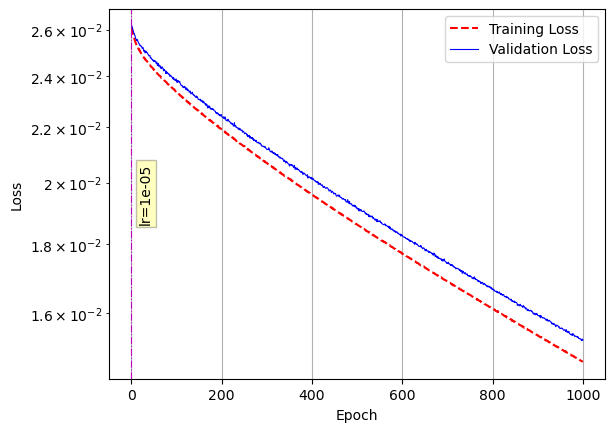

<Figure size 640x480 with 0 Axes>

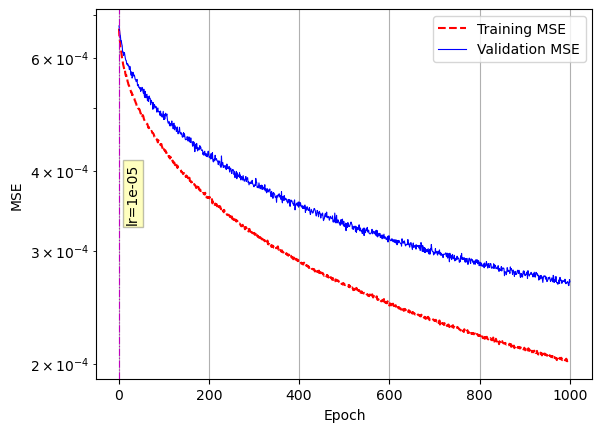

<Figure size 640x480 with 0 Axes>

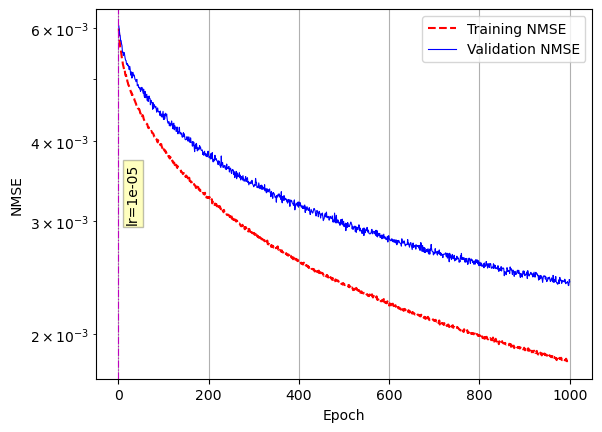

<Figure size 640x480 with 0 Axes>

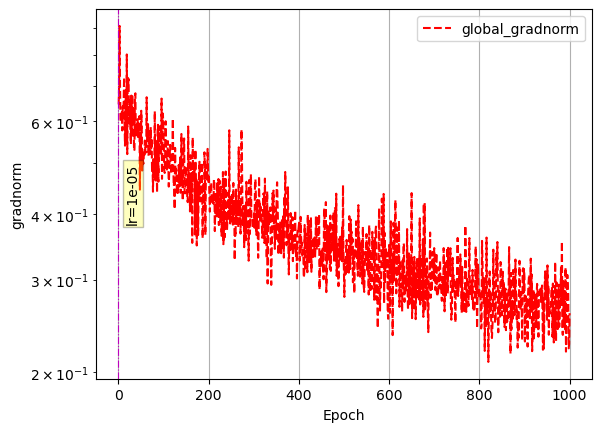

<Figure size 640x480 with 0 Axes>

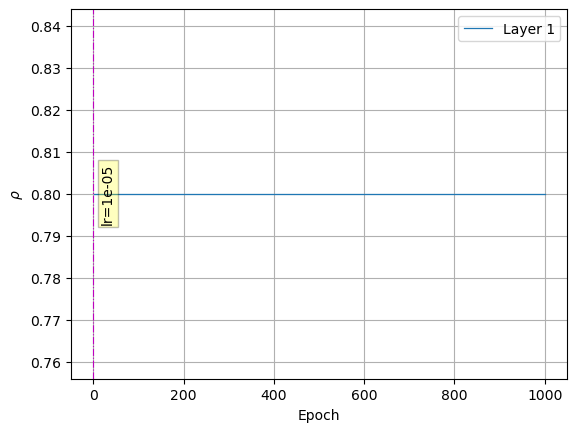

<Figure size 640x480 with 0 Axes>

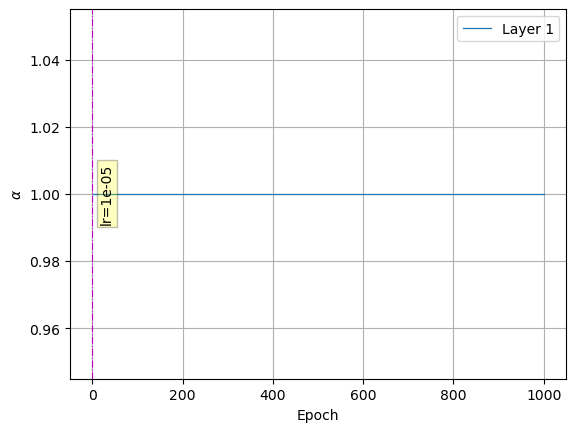

<Figure size 640x480 with 0 Axes>

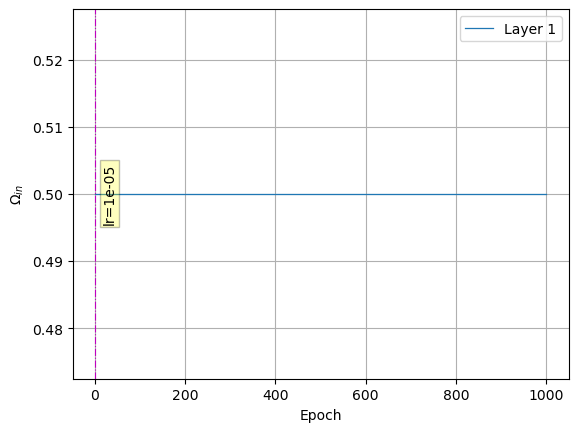



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.0
ListWrapper([False])
ListWrapper([False])
ListWrapper([False])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0190 - mse: 7.5530e-04 - NMSE: 0.0068 - covmat_fro_loss: 5.7254e-04 - global_gradnorm: 0.9955 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 0m 19.3s

Epoch 1: val_NMSE improved from inf to 0.00714, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/check

Epoch 9/1000
71/71 [==============================] - ETA: 0s - loss: 0.0184 - mse: 6.8115e-04 - NMSE: 0.0061 - covmat_fro_loss: 5.4910e-04 - global_gradnorm: 0.9846 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 1m 29.1s

Epoch 9: val_NMSE did not improve from 0.00677
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0184 - mse: 6.8115e-04 - NMSE: 0.0061 - covmat_fro_loss: 5.4886e-04 - global_gradnorm: 0.9848 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0190 - val_mse: 7.6260e-04 - val_NMSE: 0.0069 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 10/1000
71/71 [==============================] - ETA: 0s - loss: 0.0183 - mse: 6.7907e-04 - NMSE: 0.0061 - covmat_fro_loss: 5.4802e-0

71/71 [==============================] - ETA: 0s - loss: 0.0182 - mse: 6.5651e-04 - NMSE: 0.0059 - covmat_fro_loss: 5.4110e-04 - global_gradnorm: 0.9704 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 47.8s

Epoch 18: val_NMSE did not improve from 0.00671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0182 - mse: 6.5651e-04 - NMSE: 0.0059 - covmat_fro_loss: 5.4067e-04 - global_gradnorm: 0.9707 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0189 - val_mse: 7.5128e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 19/1000
71/71 [==============================] - ETA: 0s - loss: 0.0182 - mse: 6.5799e-04 - NMSE: 0.0059 - covmat_fro_loss: 5.4179e-04 - global_g

71/71 [==============================] - ETA: 0s - loss: 0.0180 - mse: 6.3744e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.3469e-04 - global_gradnorm: 0.9580 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 4m 5.5s

Epoch 27: val_NMSE improved from 0.00668 to 0.00663, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0180 - mse: 6.3744e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.3451e-04 - global_gradnorm: 0.9581 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0188 - val_mse: 7.3623e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 28/1000
71/71 [====

71/71 [==============================] - ETA: 0s - loss: 0.0179 - mse: 6.2892e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.3217e-04 - global_gradnorm: 0.9666 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 5m 23.5s

Epoch 36: val_NMSE did not improve from 0.00652
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0179 - mse: 6.2892e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.3212e-04 - global_gradnorm: 0.9671 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0187 - val_mse: 7.2971e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 37/1000
71/71 [==============================] - ETA: 0s - loss: 0.0179 - mse: 6.2698e-04 - NMSE: 0.0056 - covmat_fro_loss: 5.3155e-04 - global_g

Epoch 46/1000
71/71 [==============================] - ETA: 0s - loss: 0.0178 - mse: 6.1264e-04 - NMSE: 0.0055 - covmat_fro_loss: 5.2549e-04 - global_gradnorm: 0.9557 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 6m 49.4s

Epoch 46: val_NMSE did not improve from 0.00652
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0178 - mse: 6.1264e-04 - NMSE: 0.0055 - covmat_fro_loss: 5.2597e-04 - global_gradnorm: 0.9564 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0188 - val_mse: 7.3761e-04 - val_NMSE: 0.0066 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0178 - mse: 6.1233e-04 - NMSE: 0.0055 - covmat_fro_loss: 5.2600e

71/71 [==============================] - ETA: 0s - loss: 0.0177 - mse: 6.0449e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.2362e-04 - global_gradnorm: 0.9466 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 8m 7.2s

Epoch 55: val_NMSE did not improve from 0.00628
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0177 - mse: 6.0449e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.2413e-04 - global_gradnorm: 0.9474 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0186 - val_mse: 7.1515e-04 - val_NMSE: 0.0064 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 56/1000
71/71 [==============================] - ETA: 0s - loss: 0.0177 - mse: 6.0218e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.2180e-04 - global_gr

Epoch 65/1000
71/71 [==============================] - ETA: 0s - loss: 0.0176 - mse: 5.9618e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.1991e-04 - global_gradnorm: 0.9476 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 9m 33.3s

Epoch 65: val_NMSE did not improve from 0.00626
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0176 - mse: 5.9618e-04 - NMSE: 0.0054 - covmat_fro_loss: 5.1995e-04 - global_gradnorm: 0.9483 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0185 - val_mse: 7.0445e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 66/1000
71/71 [==============================] - ETA: 0s - loss: 0.0176 - mse: 5.9429e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.1937e

Epoch 75/1000
71/71 [==============================] - ETA: 0s - loss: 0.0175 - mse: 5.8607e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.1596e-04 - global_gradnorm: 0.9194 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 10m 59.1s

Epoch 75: val_NMSE did not improve from 0.00626
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0175 - mse: 5.8607e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.1598e-04 - global_gradnorm: 0.9205 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0186 - val_mse: 7.1739e-04 - val_NMSE: 0.0065 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 76/1000
71/71 [==============================] - ETA: 0s - loss: 0.0175 - mse: 5.8531e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.1566

Epoch 85/1000
71/71 [==============================] - ETA: 0s - loss: 0.0175 - mse: 5.7785e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.1321e-04 - global_gradnorm: 0.9196 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 12m 25.4s

Epoch 85: val_NMSE did not improve from 0.00626
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0175 - mse: 5.7785e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.1360e-04 - global_gradnorm: 0.9198 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0184 - val_mse: 7.0429e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 86/1000
71/71 [==============================] - ETA: 0s - loss: 0.0175 - mse: 5.8079e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.1388

71/71 [==============================] - ETA: 0s - loss: 0.0174 - mse: 5.7397e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.1046e-04 - global_gradnorm: 0.9196 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 42.7s

Epoch 94: val_NMSE did not improve from 0.00618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0174 - mse: 5.7397e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.1051e-04 - global_gradnorm: 0.9207 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0184 - val_mse: 6.9761e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 95/1000
71/71 [==============================] - ETA: 0s - loss: 0.0173 - mse: 5.6566e-04 - NMSE: 0.0051 - covmat_fro_loss: 5.0799e-04 - global_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0173 - mse: 5.6271e-04 - NMSE: 0.0051 - covmat_fro_loss: 5.0661e-04 - global_gradnorm: 0.9008 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0183 - val_mse: 6.8540e-04 - val_NMSE: 0.0062 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 104/1000
71/71 [==============================] - ETA: 0s - loss: 0.0173 - mse: 5.6364e-04 - NMSE: 0.0051 - covmat_fro_loss: 5.0723e-04 - global_gradnorm: 0.9156 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 15m 9.4s

Epoch 104: val_NMSE improved from 0.00617 to 0.00614, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - savin

Epoch 113/1000
71/71 [==============================] - ETA: 0s - loss: 0.0173 - mse: 5.5857e-04 - NMSE: 0.0050 - covmat_fro_loss: 5.0481e-04 - global_gradnorm: 0.9082 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 16m 26.8s

Epoch 113: val_NMSE did not improve from 0.00614
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0173 - mse: 5.5857e-04 - NMSE: 0.0050 - covmat_fro_loss: 5.0465e-04 - global_gradnorm: 0.9068 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0183 - val_mse: 6.9035e-04 - val_NMSE: 0.0062 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 114/1000
71/71 [==============================] - ETA: 0s - loss: 0.0172 - mse: 5.5570e-04 - NMSE: 0.0050 - covmat_fro_loss: 5.0

71/71 [==============================] - ETA: 0s - loss: 0.0172 - mse: 5.4943e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.0127e-04 - global_gradnorm: 0.8976 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 17m 44.8s

Epoch 122: val_NMSE did not improve from 0.00600
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 127ms/step - loss: 0.0172 - mse: 5.4943e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.0123e-04 - global_gradnorm: 0.8961 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0183 - val_mse: 6.9335e-04 - val_NMSE: 0.0062 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 123/1000
71/71 [==============================] - ETA: 0s - loss: 0.0172 - mse: 5.4999e-04 - NMSE: 0.0049 - covmat_fro_loss: 5.0165e-04 - globa

Epoch 132/1000
71/71 [==============================] - ETA: 0s - loss: 0.0171 - mse: 5.4382e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9883e-04 - global_gradnorm: 0.8905 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 19m 11.2s

Epoch 132: val_NMSE did not improve from 0.00600
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0171 - mse: 5.4382e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9866e-04 - global_gradnorm: 0.8892 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0182 - val_mse: 6.7947e-04 - val_NMSE: 0.0061 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 133/1000
71/71 [==============================] - ETA: 0s - loss: 0.0171 - mse: 5.4639e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0171 - mse: 5.4015e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9690e-04 - global_gradnorm: 0.8833 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0181 - val_mse: 6.6573e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 142/1000
71/71 [==============================] - ETA: 0s - loss: 0.0171 - mse: 5.3726e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9576e-04 - global_gradnorm: 0.8576 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 20m 37.3s

Epoch 142: val_NMSE did not improve from 0.00599
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 151/1000
71/71 [==============================] - ETA: 0s - loss: 0.0170 - mse: 5.3457e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9497e-04 - global_gradnorm: 0.8797 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 21m 55.0s

Epoch 151: val_NMSE did not improve from 0.00597
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0170 - mse: 5.3457e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9454e-04 - global_gradnorm: 0.8788 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0181 - val_mse: 6.6780e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 152/1000
71/71 [==============================] - ETA: 0s - loss: 0.0170 - mse: 5.3145e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9

71/71 [==============================] - ETA: 0s - loss: 0.0170 - mse: 5.2926e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9258e-04 - global_gradnorm: 0.8664 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 23m 12.5s

Epoch 160: val_NMSE did not improve from 0.00592
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0170 - mse: 5.2926e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9252e-04 - global_gradnorm: 0.8667 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0181 - val_mse: 6.7078e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 161/1000
71/71 [==============================] - ETA: 0s - loss: 0.0170 - mse: 5.2965e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9284e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0169 - mse: 5.2370e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8942e-04 - global_gradnorm: 0.8663 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0179 - val_mse: 6.5422e-04 - val_NMSE: 0.0059 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 170/1000
71/71 [==============================] - ETA: 0s - loss: 0.0169 - mse: 5.2312e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.9014e-04 - global_gradnorm: 0.8624 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 24m 38.8s

Epoch 170: val_NMSE did not improve from 0.00582
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 179/1000
71/71 [==============================] - ETA: 0s - loss: 0.0169 - mse: 5.1778e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8772e-04 - global_gradnorm: 0.8417 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 25m 56.0s

Epoch 179: val_NMSE improved from 0.00582 to 0.00576, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0169 - mse: 5.1778e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8781e-04 - global_gradnorm: 0.8412 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0178 - val_mse: 6.4011e-04 - val_NMSE: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0168 - mse: 5.1249e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.8504e-04 - global_gradnorm: 0.8322 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0178 - val_mse: 6.4163e-04 - val_NMSE: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 189/1000
71/71 [==============================] - ETA: 0s - loss: 0.0168 - mse: 5.1341e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.8605e-04 - global_gradnorm: 0.8388 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 27m 22.3s

Epoch 189: val_NMSE did not improve from 0.00576
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 198/1000
71/71 [==============================] - ETA: 0s - loss: 0.0168 - mse: 5.0989e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.8369e-04 - global_gradnorm: 0.8324 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 39.8s

Epoch 198: val_NMSE did not improve from 0.00572
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0168 - mse: 5.0989e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.8374e-04 - global_gradnorm: 0.8325 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0180 - val_mse: 6.6149e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 199/1000
71/71 [==============================] - ETA: 0s - loss: 0.0168 - mse: 5.1153e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.8

Epoch 208/1000
71/71 [==============================] - ETA: 0s - loss: 0.0167 - mse: 5.0268e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.8089e-04 - global_gradnorm: 0.8266 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 30m 5.3s

Epoch 208: val_NMSE did not improve from 0.00572
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0167 - mse: 5.0268e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.8101e-04 - global_gradnorm: 0.8284 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0178 - val_mse: 6.3829e-04 - val_NMSE: 0.0057 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 209/1000
71/71 [==============================] - ETA: 0s - loss: 0.0167 - mse: 5.0117e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.80

Epoch 218/1000
71/71 [==============================] - ETA: 0s - loss: 0.0167 - mse: 5.0029e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7993e-04 - global_gradnorm: 0.8237 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 31m 31.6s

Epoch 218: val_NMSE did not improve from 0.00572
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0167 - mse: 5.0029e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7975e-04 - global_gradnorm: 0.8235 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0177 - val_mse: 6.3695e-04 - val_NMSE: 0.0057 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 219/1000
71/71 [==============================] - ETA: 0s - loss: 0.0166 - mse: 4.9550e-04 - NMSE: 0.0045 - covmat_fro_loss: 4.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 127ms/step - loss: 0.0166 - mse: 4.9433e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7741e-04 - global_gradnorm: 0.8348 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0177 - val_mse: 6.3299e-04 - val_NMSE: 0.0057 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 228/1000
71/71 [==============================] - ETA: 0s - loss: 0.0166 - mse: 4.9187e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7563e-04 - global_gradnorm: 0.8215 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 32m 58.2s

Epoch 228: val_NMSE did not improve from 0.00570
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 237/1000
71/71 [==============================] - ETA: 0s - loss: 0.0166 - mse: 4.9280e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7676e-04 - global_gradnorm: 0.8556 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 34m 15.6s

Epoch 237: val_NMSE did not improve from 0.00559
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0166 - mse: 4.9280e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7703e-04 - global_gradnorm: 0.8554 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0177 - val_mse: 6.3968e-04 - val_NMSE: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 238/1000
71/71 [==============================] - ETA: 0s - loss: 0.0166 - mse: 4.9363e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7

Epoch 247/1000
71/71 [==============================] - ETA: 0s - loss: 0.0165 - mse: 4.8717e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7422e-04 - global_gradnorm: 0.8169 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 35m 41.9s

Epoch 247: val_NMSE did not improve from 0.00559
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0165 - mse: 4.8717e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7443e-04 - global_gradnorm: 0.8152 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0176 - val_mse: 6.2631e-04 - val_NMSE: 0.0056 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 248/1000
71/71 [==============================] - ETA: 0s - loss: 0.0165 - mse: 4.8560e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 125ms/step - loss: 0.0164 - mse: 4.7990e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.7020e-04 - global_gradnorm: 0.7861 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0176 - val_mse: 6.2400e-04 - val_NMSE: 0.0056 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 257/1000
71/71 [==============================] - ETA: 0s - loss: 0.0165 - mse: 4.8272e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.7192e-04 - global_gradnorm: 0.8070 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 37m 8.3s

Epoch 257: val_NMSE did not improve from 0.00557
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 266/1000
71/71 [==============================] - ETA: 0s - loss: 0.0164 - mse: 4.7648e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6931e-04 - global_gradnorm: 0.7975 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 38m 25.5s

Epoch 266: val_NMSE did not improve from 0.00553
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0164 - mse: 4.7648e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6923e-04 - global_gradnorm: 0.7985 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0176 - val_mse: 6.2933e-04 - val_NMSE: 0.0057 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 267/1000
71/71 [==============================] - ETA: 0s - loss: 0.0164 - mse: 4.8029e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0164 - mse: 4.7300e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6744e-04 - global_gradnorm: 0.7997 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0174 - val_mse: 6.1186e-04 - val_NMSE: 0.0055 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 276/1000
71/71 [==============================] - ETA: 0s - loss: 0.0164 - mse: 4.7563e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6862e-04 - global_gradnorm: 0.7939 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 39m 51.9s

Epoch 276: val_NMSE did not improve from 0.00551
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 285/1000
71/71 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.7265e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6724e-04 - global_gradnorm: 0.7987 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 41m 9.3s

Epoch 285: val_NMSE did not improve from 0.00548
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0163 - mse: 4.7265e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6754e-04 - global_gradnorm: 0.7997 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0175 - val_mse: 6.1733e-04 - val_NMSE: 0.0056 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 286/1000
71/71 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.7326e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.67

Epoch 295/1000
71/71 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.6711e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.6437e-04 - global_gradnorm: 0.7926 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 42m 35.2s

Epoch 295: val_NMSE did not improve from 0.00548
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 120ms/step - loss: 0.0163 - mse: 4.6711e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.6429e-04 - global_gradnorm: 0.7915 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0174 - val_mse: 6.1673e-04 - val_NMSE: 0.0056 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 296/1000
71/71 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.6680e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0163 - mse: 4.6590e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.6431e-04 - global_gradnorm: 0.8016 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0174 - val_mse: 6.1029e-04 - val_NMSE: 0.0055 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 305/1000
71/71 [==============================] - ETA: 0s - loss: 0.0163 - mse: 4.6877e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.6496e-04 - global_gradnorm: 0.8018 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 44m 1.2s

Epoch 305: val_NMSE did not improve from 0.00546
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 314/1000
71/71 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.6255e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.6314e-04 - global_gradnorm: 0.7894 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 45m 18.8s

Epoch 314: val_NMSE did not improve from 0.00529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0162 - mse: 4.6255e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.6334e-04 - global_gradnorm: 0.7890 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0174 - val_mse: 6.1281e-04 - val_NMSE: 0.0055 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 315/1000
71/71 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.5873e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6

Epoch 324/1000
71/71 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.5709e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6057e-04 - global_gradnorm: 0.7835 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 46m 45.1s

Epoch 324: val_NMSE did not improve from 0.00529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0162 - mse: 4.5709e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6105e-04 - global_gradnorm: 0.7829 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0173 - val_mse: 6.0135e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 325/1000
71/71 [==============================] - ETA: 0s - loss: 0.0162 - mse: 4.5864e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.6

Epoch 334/1000
71/71 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.5644e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5965e-04 - global_gradnorm: 0.7663 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 48m 12.2s

Epoch 334: val_NMSE did not improve from 0.00529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0161 - mse: 4.5644e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5978e-04 - global_gradnorm: 0.7655 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0172 - val_mse: 5.9224e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 335/1000
71/71 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.5471e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5

Epoch 344/1000
71/71 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.4939e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5574e-04 - global_gradnorm: 0.7583 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 49m 39.4s

Epoch 344: val_NMSE did not improve from 0.00529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0161 - mse: 4.4939e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5625e-04 - global_gradnorm: 0.7611 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0172 - val_mse: 6.0015e-04 - val_NMSE: 0.0054 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 345/1000
71/71 [==============================] - ETA: 0s - loss: 0.0161 - mse: 4.5050e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5

Epoch 354/1000
71/71 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.4561e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5467e-04 - global_gradnorm: 0.7326 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 51m 6.3s

Epoch 354: val_NMSE did not improve from 0.00529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0160 - mse: 4.4561e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5430e-04 - global_gradnorm: 0.7311 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0172 - val_mse: 5.9263e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 355/1000
71/71 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.4650e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.55

Epoch 364/1000
71/71 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.4411e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5386e-04 - global_gradnorm: 0.7564 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 33.4s

Epoch 364: val_NMSE did not improve from 0.00529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0160 - mse: 4.4411e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5415e-04 - global_gradnorm: 0.7575 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0172 - val_mse: 6.0579e-04 - val_NMSE: 0.0055 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 365/1000
71/71 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.4844e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5

Epoch 374/1000
71/71 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.4500e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5409e-04 - global_gradnorm: 0.7636 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 53m 59.7s

Epoch 374: val_NMSE did not improve from 0.00529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0160 - mse: 4.4500e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5385e-04 - global_gradnorm: 0.7630 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0171 - val_mse: 5.9005e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 375/1000
71/71 [==============================] - ETA: 0s - loss: 0.0160 - mse: 4.4450e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5

71/71 [==============================] - ETA: 0s - loss: 0.0159 - mse: 4.3875e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5107e-04 - global_gradnorm: 0.7459 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 55m 17.8s

Epoch 383: val_NMSE did not improve from 0.00523
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0159 - mse: 4.3875e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5088e-04 - global_gradnorm: 0.7454 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0171 - val_mse: 5.9185e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 384/1000
71/71 [==============================] - ETA: 0s - loss: 0.0159 - mse: 4.3772e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5045e-04 - globa

71/71 [==============================] - ETA: 0s - loss: 0.0159 - mse: 4.4015e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5183e-04 - global_gradnorm: 0.7810 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 56m 35.6s

Epoch 392: val_NMSE did not improve from 0.00520
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0159 - mse: 4.4015e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.5192e-04 - global_gradnorm: 0.7804 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0171 - val_mse: 5.9045e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 393/1000
71/71 [==============================] - ETA: 0s - loss: 0.0159 - mse: 4.3781e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5042e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 126ms/step - loss: 0.0158 - mse: 4.3210e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4776e-04 - global_gradnorm: 0.7470 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0170 - val_mse: 5.7734e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 402/1000
71/71 [==============================] - ETA: 0s - loss: 0.0158 - mse: 4.3193e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4771e-04 - global_gradnorm: 0.7359 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 58m 2.1s

Epoch 402: val_NMSE improved from 0.00520 to 0.00517, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - savin

Epoch 411/1000
71/71 [==============================] - ETA: 0s - loss: 0.0158 - mse: 4.3031e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4716e-04 - global_gradnorm: 0.7247 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 59m 19.8s

Epoch 411: val_NMSE improved from 0.00517 to 0.00517, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0158 - mse: 4.3031e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4709e-04 - global_gradnorm: 0.7242 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0169 - val_mse: 5.7406e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 4

71/71 [==============================] - ETA: 0s - loss: 0.0157 - mse: 4.2583e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4493e-04 - global_gradnorm: 0.7164 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 0m 37.6s

Epoch 420: val_NMSE did not improve from 0.00515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0157 - mse: 4.2583e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4457e-04 - global_gradnorm: 0.7177 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0169 - val_mse: 5.7535e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 421/1000
71/71 [==============================] - ETA: 0s - loss: 0.0157 - mse: 4.2598e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4467e-04 - global

Epoch 429/1000
71/71 [==============================] - ETA: 0s - loss: 0.0157 - mse: 4.2639e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4571e-04 - global_gradnorm: 0.7245 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 1m 55.7s

Epoch 429: val_NMSE did not improve from 0.00506
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0157 - mse: 4.2639e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4614e-04 - global_gradnorm: 0.7253 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0169 - val_mse: 5.7017e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 430/1000
71/71 [==============================] - ETA: 0s - loss: 0.0157 - mse: 4.2596e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.45

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0157 - mse: 4.2198e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4337e-04 - global_gradnorm: 0.7271 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0170 - val_mse: 5.9139e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 439/1000
71/71 [==============================] - ETA: 0s - loss: 0.0157 - mse: 4.2496e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4477e-04 - global_gradnorm: 0.7227 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 3m 22.6s

Epoch 439: val_NMSE did not improve from 0.00506
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 448/1000
71/71 [==============================] - ETA: 0s - loss: 0.0156 - mse: 4.1855e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4140e-04 - global_gradnorm: 0.7092 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 4m 40.5s

Epoch 448: val_NMSE did not improve from 0.00505
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0156 - mse: 4.1855e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.4116e-04 - global_gradnorm: 0.7089 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0168 - val_mse: 5.7201e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 449/1000
71/71 [==============================] - ETA: 0s - loss: 0.0156 - mse: 4.1764e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.40

Epoch 458/1000
71/71 [==============================] - ETA: 0s - loss: 0.0156 - mse: 4.1366e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3919e-04 - global_gradnorm: 0.6942 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 6m 6.3s

Epoch 458: val_NMSE did not improve from 0.00505
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0156 - mse: 4.1366e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3896e-04 - global_gradnorm: 0.6939 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0168 - val_mse: 5.7431e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 459/1000
71/71 [==============================] - ETA: 0s - loss: 0.0156 - mse: 4.1806e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.407

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0156 - mse: 4.1447e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3904e-04 - global_gradnorm: 0.7150 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0168 - val_mse: 5.7043e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 468/1000
71/71 [==============================] - ETA: 0s - loss: 0.0156 - mse: 4.1518e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3956e-04 - global_gradnorm: 0.7210 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 7m 32.8s

Epoch 468: val_NMSE did not improve from 0.00504
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 477/1000
71/71 [==============================] - ETA: 0s - loss: 0.0155 - mse: 4.1107e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3752e-04 - global_gradnorm: 0.6940 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 8m 50.7s

Epoch 477: val_NMSE improved from 0.00501 to 0.00497, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0155 - mse: 4.1107e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3768e-04 - global_gradnorm: 0.6953 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0166 - val_mse: 5.5238e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 47

71/71 [==============================] - ETA: 0s - loss: 0.0155 - mse: 4.0709e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3537e-04 - global_gradnorm: 0.6901 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 10m 8.4s

Epoch 486: val_NMSE did not improve from 0.00497
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0155 - mse: 4.0709e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3537e-04 - global_gradnorm: 0.6909 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0167 - val_mse: 5.5794e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 487/1000
71/71 [==============================] - ETA: 0s - loss: 0.0155 - mse: 4.1095e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3751e-04 - global

Epoch 496/1000
71/71 [==============================] - ETA: 0s - loss: 0.0155 - mse: 4.0761e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3554e-04 - global_gradnorm: 0.7130 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 11m 34.6s

Epoch 496: val_NMSE did not improve from 0.00497
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0155 - mse: 4.0761e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3545e-04 - global_gradnorm: 0.7135 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0167 - val_mse: 5.5913e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 497/1000
71/71 [==============================] - ETA: 0s - loss: 0.0154 - mse: 4.0458e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0154 - mse: 4.0618e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3544e-04 - global_gradnorm: 0.7203 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0167 - val_mse: 5.6075e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 506/1000
71/71 [==============================] - ETA: 0s - loss: 0.0155 - mse: 4.0791e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3557e-04 - global_gradnorm: 0.7323 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 13m 0.5s

Epoch 506: val_NMSE did not improve from 0.00496
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 515/1000
71/71 [==============================] - ETA: 0s - loss: 0.0154 - mse: 4.0088e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3231e-04 - global_gradnorm: 0.6810 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 14m 18.4s

Epoch 515: val_NMSE did not improve from 0.00490
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 119ms/step - loss: 0.0154 - mse: 4.0088e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3232e-04 - global_gradnorm: 0.6816 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0165 - val_mse: 5.4648e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 516/1000
71/71 [==============================] - ETA: 0s - loss: 0.0154 - mse: 4.0245e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3

Epoch 525/1000
71/71 [==============================] - ETA: 0s - loss: 0.0154 - mse: 4.0061e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3259e-04 - global_gradnorm: 0.7101 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 15m 44.6s

Epoch 525: val_NMSE did not improve from 0.00490
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0154 - mse: 4.0061e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3249e-04 - global_gradnorm: 0.7126 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0166 - val_mse: 5.5475e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 526/1000
71/71 [==============================] - ETA: 0s - loss: 0.0154 - mse: 4.0043e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3

71/71 [==============================] - ETA: 0s - loss: 0.0153 - mse: 3.9750e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3042e-04 - global_gradnorm: 0.7087 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 17m 2.3s

Epoch 534: val_NMSE did not improve from 0.00487
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0153 - mse: 3.9750e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3053e-04 - global_gradnorm: 0.7092 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0165 - val_mse: 5.4940e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 535/1000
71/71 [==============================] - ETA: 0s - loss: 0.0153 - mse: 3.9933e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.3138e-04 - global

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0153 - mse: 3.9692e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2973e-04 - global_gradnorm: 0.6895 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0165 - val_mse: 5.4842e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 544/1000
71/71 [==============================] - ETA: 0s - loss: 0.0153 - mse: 3.9429e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2893e-04 - global_gradnorm: 0.6720 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 18m 28.7s

Epoch 544: val_NMSE did not improve from 0.00483
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 553/1000
71/71 [==============================] - ETA: 0s - loss: 0.0153 - mse: 3.9445e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2888e-04 - global_gradnorm: 0.6879 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 19m 47.6s

Epoch 553: val_NMSE improved from 0.00483 to 0.00483, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 126ms/step - loss: 0.0153 - mse: 3.9445e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2877e-04 - global_gradnorm: 0.6873 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0164 - val_mse: 5.3639e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 5

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0152 - mse: 3.9141e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2709e-04 - global_gradnorm: 0.6911 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0165 - val_mse: 5.5386e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 563/1000
71/71 [==============================] - ETA: 0s - loss: 0.0152 - mse: 3.9357e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2843e-04 - global_gradnorm: 0.6911 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 21m 14.8s

Epoch 563: val_NMSE did not improve from 0.00483
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 572/1000
71/71 [==============================] - ETA: 0s - loss: 0.0152 - mse: 3.9035e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2743e-04 - global_gradnorm: 0.7003 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 22m 34.1s

Epoch 572: val_NMSE did not improve from 0.00476
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0152 - mse: 3.9035e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2715e-04 - global_gradnorm: 0.6997 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0164 - val_mse: 5.4321e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 573/1000
71/71 [==============================] - ETA: 0s - loss: 0.0152 - mse: 3.8933e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2

Epoch 582/1000
71/71 [==============================] - ETA: 0s - loss: 0.0152 - mse: 3.8821e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2531e-04 - global_gradnorm: 0.6784 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 1.6s

Epoch 582: val_NMSE did not improve from 0.00476
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0152 - mse: 3.8821e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2514e-04 - global_gradnorm: 0.6793 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0163 - val_mse: 5.3809e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 583/1000
71/71 [==============================] - ETA: 0s - loss: 0.0151 - mse: 3.8470e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.23

Epoch 592/1000
71/71 [==============================] - ETA: 0s - loss: 0.0151 - mse: 3.8612e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2472e-04 - global_gradnorm: 0.6686 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 25m 29.1s

Epoch 592: val_NMSE did not improve from 0.00476
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 126ms/step - loss: 0.0151 - mse: 3.8612e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2462e-04 - global_gradnorm: 0.6696 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0162 - val_mse: 5.2951e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 593/1000
71/71 [==============================] - ETA: 0s - loss: 0.0151 - mse: 3.8223e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2

71/71 [==============================] - ETA: 0s - loss: 0.0151 - mse: 3.8376e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2302e-04 - global_gradnorm: 0.6795 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 26m 47.5s

Epoch 601: val_NMSE did not improve from 0.00470
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0151 - mse: 3.8376e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2266e-04 - global_gradnorm: 0.6785 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0163 - val_mse: 5.4260e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 602/1000
71/71 [==============================] - ETA: 0s - loss: 0.0151 - mse: 3.8173e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2245e-04 - globa

Epoch 611/1000
71/71 [==============================] - ETA: 0s - loss: 0.0151 - mse: 3.8338e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2352e-04 - global_gradnorm: 0.6903 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 28m 14.7s

Epoch 611: val_NMSE did not improve from 0.00470
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0151 - mse: 3.8338e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.2344e-04 - global_gradnorm: 0.6897 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0162 - val_mse: 5.2313e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 612/1000
71/71 [==============================] - ETA: 0s - loss: 0.0150 - mse: 3.8107e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2

Epoch 621/1000
71/71 [==============================] - ETA: 0s - loss: 0.0150 - mse: 3.7773e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1982e-04 - global_gradnorm: 0.6684 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 29m 41.9s

Epoch 621: val_NMSE did not improve from 0.00470
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0150 - mse: 3.7773e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1989e-04 - global_gradnorm: 0.6670 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0163 - val_mse: 5.4240e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 622/1000
71/71 [==============================] - ETA: 0s - loss: 0.0150 - mse: 3.7972e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0150 - mse: 3.7712e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1961e-04 - global_gradnorm: 0.6466 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0161 - val_mse: 5.2362e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 631/1000
71/71 [==============================] - ETA: 0s - loss: 0.0150 - mse: 3.7462e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1867e-04 - global_gradnorm: 0.6334 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 31m 9.7s

Epoch 631: val_NMSE did not improve from 0.00468
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 640/1000
71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 3.7481e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1860e-04 - global_gradnorm: 0.6479 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 32m 28.8s

Epoch 640: val_NMSE did not improve from 0.00467
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 121ms/step - loss: 0.0149 - mse: 3.7481e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1840e-04 - global_gradnorm: 0.6464 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0161 - val_mse: 5.2639e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 641/1000
71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 3.7544e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0149 - mse: 3.7504e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1858e-04 - global_gradnorm: 0.6687 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0161 - val_mse: 5.2749e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 650/1000
71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 3.7271e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1749e-04 - global_gradnorm: 0.6525 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 33m 56.1s

Epoch 650: val_NMSE did not improve from 0.00466
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 659/1000
71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 3.7173e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1664e-04 - global_gradnorm: 0.6547 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 35m 14.8s

Epoch 659: val_NMSE did not improve from 0.00463
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0149 - mse: 3.7173e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1712e-04 - global_gradnorm: 0.6546 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0160 - val_mse: 5.1715e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 660/1000
71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 3.7309e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 125ms/step - loss: 0.0148 - mse: 3.6908e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1610e-04 - global_gradnorm: 0.6514 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0160 - val_mse: 5.2056e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 669/1000
71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 3.6752e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1502e-04 - global_gradnorm: 0.6336 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 36m 42.5s

Epoch 669: val_NMSE did not improve from 0.00463
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 678/1000
71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 3.6988e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1633e-04 - global_gradnorm: 0.6527 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 38m 1.1s

Epoch 678: val_NMSE did not improve from 0.00463
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0148 - mse: 3.6988e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1670e-04 - global_gradnorm: 0.6564 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0160 - val_mse: 5.2213e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 679/1000
71/71 [==============================] - ETA: 0s - loss: 0.0149 - mse: 3.7200e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.17

Epoch 688/1000
71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 3.6734e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1495e-04 - global_gradnorm: 0.6438 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 39m 28.6s

Epoch 688: val_NMSE improved from 0.00463 to 0.00462, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0148 - mse: 3.6734e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1483e-04 - global_gradnorm: 0.6428 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0159 - val_mse: 5.1305e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 6

71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 3.6517e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1369e-04 - global_gradnorm: 0.6348 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 40m 47.4s

Epoch 697: val_NMSE did not improve from 0.00459
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0148 - mse: 3.6517e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1407e-04 - global_gradnorm: 0.6361 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0160 - val_mse: 5.2696e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 698/1000
71/71 [==============================] - ETA: 0s - loss: 0.0148 - mse: 3.6455e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1285e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0147 - mse: 3.6372e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1290e-04 - global_gradnorm: 0.6448 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0160 - val_mse: 5.2066e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 707/1000
71/71 [==============================] - ETA: 0s - loss: 0.0147 - mse: 3.6153e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.1188e-04 - global_gradnorm: 0.6280 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 42m 14.9s

Epoch 707: val_NMSE did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 716/1000
71/71 [==============================] - ETA: 0s - loss: 0.0147 - mse: 3.6015e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1085e-04 - global_gradnorm: 0.6247 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 43m 33.9s

Epoch 716: val_NMSE did not improve from 0.00453
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0147 - mse: 3.6015e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1114e-04 - global_gradnorm: 0.6247 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0159 - val_mse: 5.1383e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 717/1000
71/71 [==============================] - ETA: 0s - loss: 0.0147 - mse: 3.5990e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1

Epoch 726/1000
71/71 [==============================] - ETA: 0s - loss: 0.0147 - mse: 3.5892e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0992e-04 - global_gradnorm: 0.6292 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 45m 1.5s

Epoch 726: val_NMSE did not improve from 0.00453
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0147 - mse: 3.5892e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1038e-04 - global_gradnorm: 0.6299 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0159 - val_mse: 5.1078e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 727/1000
71/71 [==============================] - ETA: 0s - loss: 0.0147 - mse: 3.5919e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.10

71/71 [==============================] - ETA: 0s - loss: 0.0146 - mse: 3.5711e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0936e-04 - global_gradnorm: 0.6214 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 46m 20.2s

Epoch 735: val_NMSE did not improve from 0.00451
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0146 - mse: 3.5711e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0896e-04 - global_gradnorm: 0.6195 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0158 - val_mse: 5.0317e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 736/1000
71/71 [==============================] - ETA: 0s - loss: 0.0146 - mse: 3.5938e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1049e-04 - globa

Epoch 745/1000
71/71 [==============================] - ETA: 0s - loss: 0.0146 - mse: 3.5736e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0909e-04 - global_gradnorm: 0.6599 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 47m 47.4s

Epoch 745: val_NMSE improved from 0.00451 to 0.00450, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0146 - mse: 3.5736e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0899e-04 - global_gradnorm: 0.6596 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0157 - val_mse: 5.0002e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 7

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 125ms/step - loss: 0.0146 - mse: 3.5661e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0881e-04 - global_gradnorm: 0.6375 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0158 - val_mse: 5.0645e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 755/1000
71/71 [==============================] - ETA: 0s - loss: 0.0146 - mse: 3.5771e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0886e-04 - global_gradnorm: 0.6294 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 49m 15.3s

Epoch 755: val_NMSE did not improve from 0.00450
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 764/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 3.5433e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0791e-04 - global_gradnorm: 0.6316 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 50m 34.1s

Epoch 764: val_NMSE did not improve from 0.00446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0145 - mse: 3.5433e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0806e-04 - global_gradnorm: 0.6309 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0158 - val_mse: 5.1122e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 765/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 3.5242e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0145 - mse: 3.5099e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0582e-04 - global_gradnorm: 0.6244 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0157 - val_mse: 5.0407e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 774/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 3.5118e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0599e-04 - global_gradnorm: 0.6211 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 52m 1.6s

Epoch 774: val_NMSE did not improve from 0.00446
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-

Epoch 783/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 3.5268e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0629e-04 - global_gradnorm: 0.6456 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 53m 20.7s

Epoch 783: val_NMSE did not improve from 0.00441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0145 - mse: 3.5268e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0624e-04 - global_gradnorm: 0.6453 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0156 - val_mse: 4.9380e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 784/1000
71/71 [==============================] - ETA: 0s - loss: 0.0145 - mse: 3.5082e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0145 - mse: 3.4868e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0423e-04 - global_gradnorm: 0.6406 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0156 - val_mse: 5.0016e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 793/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 3.4876e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0416e-04 - global_gradnorm: 0.6267 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 54m 48.0s

Epoch 793: val_NMSE did not improve from 0.00441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 802/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 3.4499e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0275e-04 - global_gradnorm: 0.5951 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 56m 6.6s

Epoch 802: val_NMSE improved from 0.00439 to 0.00437, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 127ms/step - loss: 0.0144 - mse: 3.4499e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0270e-04 - global_gradnorm: 0.5954 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0155 - val_mse: 4.8575e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 80

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0144 - mse: 3.4738e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0385e-04 - global_gradnorm: 0.6170 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0155 - val_mse: 4.8786e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 812/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 3.4893e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0506e-04 - global_gradnorm: 0.6308 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 57m 33.8s

Epoch 812: val_NMSE did not improve from 0.00437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 821/1000
71/71 [==============================] - ETA: 0s - loss: 0.0144 - mse: 3.4448e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0215e-04 - global_gradnorm: 0.6127 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 58m 52.4s

Epoch 821: val_NMSE did not improve from 0.00436
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0144 - mse: 3.4448e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0231e-04 - global_gradnorm: 0.6143 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0155 - val_mse: 4.9184e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 822/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 3.4296e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0

Epoch 831/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 3.4175e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0079e-04 - global_gradnorm: 0.5977 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 0m 19.9s

Epoch 831: val_NMSE did not improve from 0.00436
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0143 - mse: 3.4175e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0098e-04 - global_gradnorm: 0.5986 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0155 - val_mse: 4.8988e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 832/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 3.4215e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.00

Epoch 841/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 3.3900e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9894e-04 - global_gradnorm: 0.5971 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 1m 47.3s

Epoch 841: val_NMSE did not improve from 0.00436
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0143 - mse: 3.3900e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9903e-04 - global_gradnorm: 0.5974 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0154 - val_mse: 4.8510e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 842/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 3.3946e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.99

71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 3.3795e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9836e-04 - global_gradnorm: 0.5815 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 3m 6.2s

Epoch 850: val_NMSE did not improve from 0.00432
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0143 - mse: 3.3795e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9842e-04 - global_gradnorm: 0.5824 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0154 - val_mse: 4.8844e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 851/1000
71/71 [==============================] - ETA: 0s - loss: 0.0143 - mse: 3.3959e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9900e-04 - global_

Epoch 860/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 3.3704e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9809e-04 - global_gradnorm: 0.5811 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 4m 33.6s

Epoch 860: val_NMSE did not improve from 0.00432
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0142 - mse: 3.3704e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9854e-04 - global_gradnorm: 0.5812 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0154 - val_mse: 4.8447e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 861/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 3.3895e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.99

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 125ms/step - loss: 0.0142 - mse: 3.3735e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9826e-04 - global_gradnorm: 0.5969 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0153 - val_mse: 4.7968e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 870/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 3.3780e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9838e-04 - global_gradnorm: 0.6163 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 6m 1.3s

Epoch 870: val_NMSE did not improve from 0.00432
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-1

Epoch 879/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 3.3288e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9575e-04 - global_gradnorm: 0.5883 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 7m 20.2s

Epoch 879: val_NMSE did not improve from 0.00432
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 127ms/step - loss: 0.0142 - mse: 3.3288e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9617e-04 - global_gradnorm: 0.5873 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0154 - val_mse: 4.8836e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 880/1000
71/71 [==============================] - ETA: 0s - loss: 0.0142 - mse: 3.3399e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.96

71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 3.3229e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9524e-04 - global_gradnorm: 0.5801 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 8m 39.2s

Epoch 888: val_NMSE improved from 0.00430 to 0.00430, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 126ms/step - loss: 0.0141 - mse: 3.3229e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9531e-04 - global_gradnorm: 0.5794 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0153 - val_mse: 4.7734e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 889/1000
71/71 [=

71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 3.3334e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9573e-04 - global_gradnorm: 0.6010 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 9m 58.4s

Epoch 897: val_NMSE did not improve from 0.00429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0141 - mse: 3.3334e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9585e-04 - global_gradnorm: 0.6018 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0154 - val_mse: 4.8915e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 898/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 3.3406e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9614e-04 - global

Epoch 907/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 3.3274e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9572e-04 - global_gradnorm: 0.5988 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 11m 25.6s

Epoch 907: val_NMSE did not improve from 0.00429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0141 - mse: 3.3274e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9580e-04 - global_gradnorm: 0.5991 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0153 - val_mse: 4.8472e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 908/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 3.2871e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9

71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 3.2927e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9331e-04 - global_gradnorm: 0.5834 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 12m 44.9s

Epoch 916: val_NMSE did not improve from 0.00425
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0141 - mse: 3.2927e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9299e-04 - global_gradnorm: 0.5825 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0153 - val_mse: 4.8377e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 917/1000
71/71 [==============================] - ETA: 0s - loss: 0.0141 - mse: 3.3053e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9474e-04 - globa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0140 - mse: 3.2950e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9329e-04 - global_gradnorm: 0.5989 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0153 - val_mse: 4.8416e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 926/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 3.2841e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9253e-04 - global_gradnorm: 0.5951 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 14m 12.6s

Epoch 926: val_NMSE did not improve from 0.00424
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 935/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 3.2990e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9353e-04 - global_gradnorm: 0.6255 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 15m 31.2s

Epoch 935: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0140 - mse: 3.2990e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9392e-04 - global_gradnorm: 0.6250 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0152 - val_mse: 4.7390e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 936/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 3.3018e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9

Epoch 945/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 3.2858e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9285e-04 - global_gradnorm: 0.5986 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 16m 58.6s

Epoch 945: val_NMSE did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0140 - mse: 3.2858e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9261e-04 - global_gradnorm: 0.5971 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0151 - val_mse: 4.7312e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 946/1000
71/71 [==============================] - ETA: 0s - loss: 0.0140 - mse: 3.2814e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9

71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 3.2301e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8958e-04 - global_gradnorm: 0.5639 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 18m 17.6s

Epoch 954: val_NMSE improved from 0.00422 to 0.00416, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 124ms/step - loss: 0.0139 - mse: 3.2301e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8946e-04 - global_gradnorm: 0.5630 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0150 - val_mse: 4.6222e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 955/1000
71/71 [

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0139 - mse: 3.2533e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9092e-04 - global_gradnorm: 0.5972 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0151 - val_mse: 4.7442e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 964/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 3.2161e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8887e-04 - global_gradnorm: 0.5607 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 19m 45.0s

Epoch 964: val_NMSE did not improve from 0.00416
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint

Epoch 973/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 3.2314e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8976e-04 - global_gradnorm: 0.5817 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 21m 3.5s

Epoch 973: val_NMSE did not improve from 0.00414
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 122ms/step - loss: 0.0139 - mse: 3.2314e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8974e-04 - global_gradnorm: 0.5836 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0151 - val_mse: 4.7759e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 974/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 3.2142e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.88

Epoch 983/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 3.1907e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8750e-04 - global_gradnorm: 0.5702 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 22m 30.5s

Epoch 983: val_NMSE did not improve from 0.00414
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 123ms/step - loss: 0.0138 - mse: 3.1907e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8750e-04 - global_gradnorm: 0.5709 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0150 - val_mse: 4.6733e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 984/1000
71/71 [==============================] - ETA: 0s - loss: 0.0139 - mse: 3.2176e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8

Epoch 993/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 3.1972e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8778e-04 - global_gradnorm: 0.5707 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 23m 57.4s

Epoch 993: val_NMSE did not improve from 0.00414
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 9s 120ms/step - loss: 0.0138 - mse: 3.1972e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8798e-04 - global_gradnorm: 0.5734 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0150 - val_mse: 4.6433e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 994/1000
71/71 [==============================] - ETA: 0s - loss: 0.0138 - mse: 3.1840e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8

<Figure size 640x480 with 0 Axes>

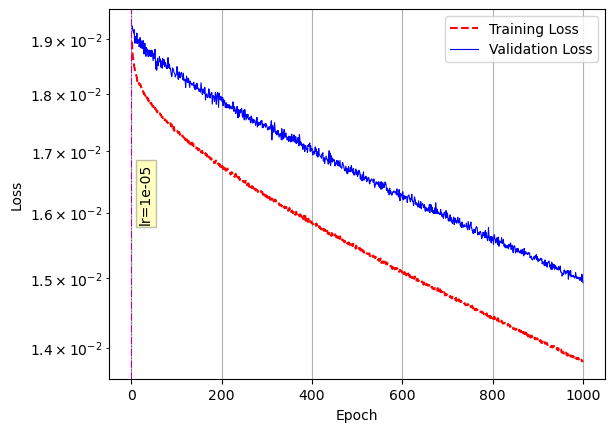

<Figure size 640x480 with 0 Axes>

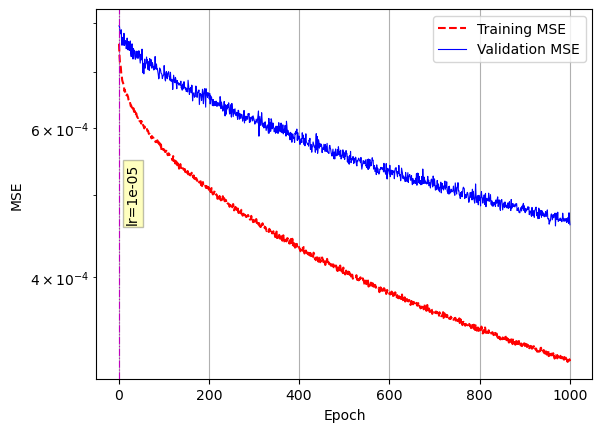

<Figure size 640x480 with 0 Axes>

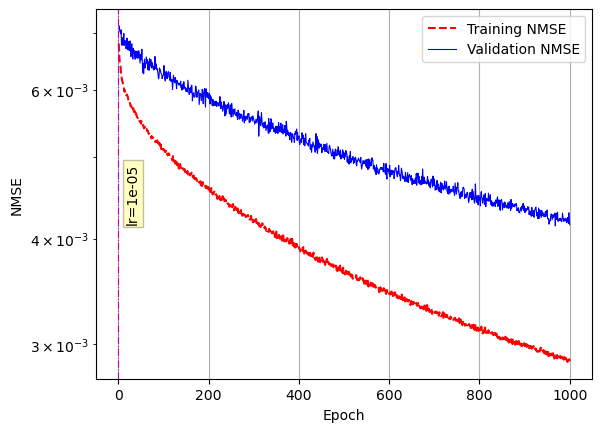

<Figure size 640x480 with 0 Axes>

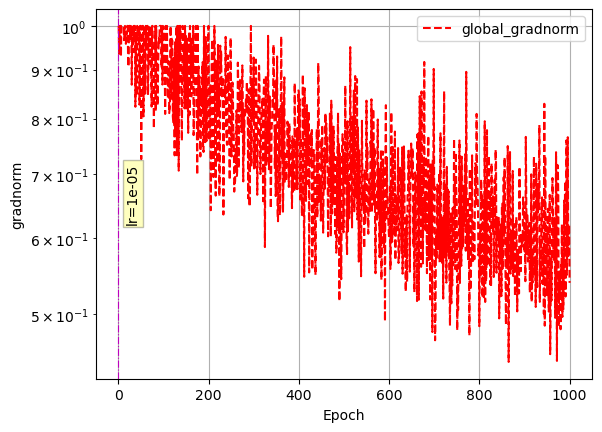

<Figure size 640x480 with 0 Axes>

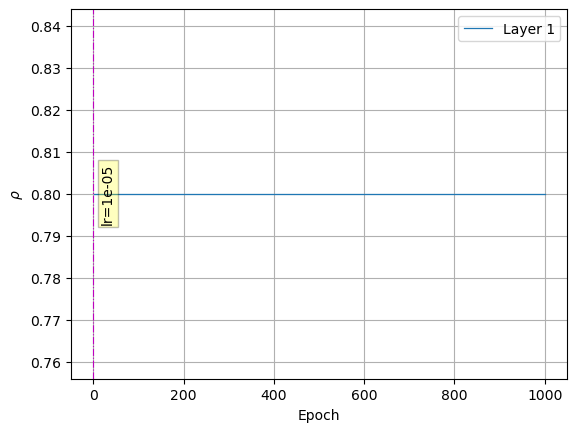

<Figure size 640x480 with 0 Axes>

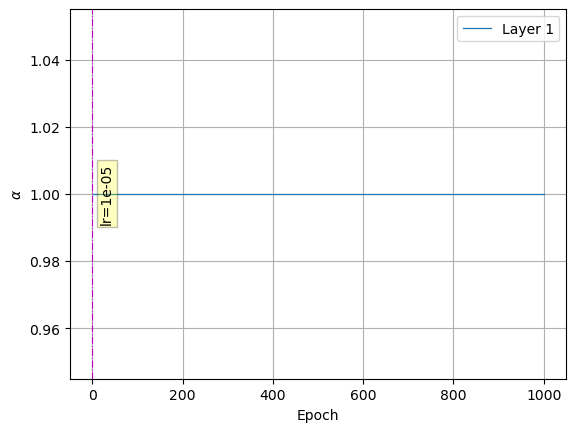

<Figure size 640x480 with 0 Axes>

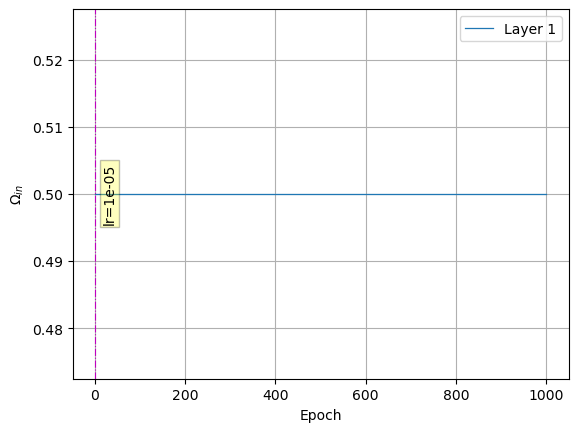



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.0
ListWrapper([False])
ListWrapper([False])
ListWrapper([False])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0274 - mse: 0.0028 - NMSE: 0.0249 - covmat_fro_loss: 0.0020 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 0m 41.2s

Epoch 1: val_NMSE improved from inf to 0.02503, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-30

58/58 [==============================] - ETA: 0s - loss: 0.0260 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0019 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 1.6s

Epoch 9: val_NMSE did not improve from 0.02391
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0260 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0019 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0274 - val_mse: 0.0028 - val_NMSE: 0.0248 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 10/1000
58/58 [==============================] - ETA: 0s - loss: 0.0260 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0019 - global_gradnorm: 1.0000 - rho_res_0: 

Epoch 19/1000
58/58 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0019 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 3m 41.2s

Epoch 19: val_NMSE did not improve from 0.02390
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0254 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0019 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0272 - val_mse: 0.0027 - val_NMSE: 0.0246 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 20/1000
58/58 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0019 - global_gradnorm: 1.00

Epoch 29/1000
58/58 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0023 - NMSE: 0.0211 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 5m 21.0s

Epoch 29: val_NMSE did not improve from 0.02378
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0250 - mse: 0.0023 - NMSE: 0.0211 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0268 - val_mse: 0.0027 - val_NMSE: 0.0240 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 30/1000
58/58 [==============================] - ETA: 0s - loss: 0.0249 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.00

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0247 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0265 - val_mse: 0.0026 - val_NMSE: 0.0234 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 39/1000
58/58 [==============================] - ETA: 0s - loss: 0.0247 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 7m 1.1s

Epoch 39: val_NMSE did not improve from 0.02335
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [===

58/58 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0022 - NMSE: 0.0202 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 8m 31.0s

Epoch 48: val_NMSE did not improve from 0.02335
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0244 - mse: 0.0022 - NMSE: 0.0202 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0267 - val_mse: 0.0026 - val_NMSE: 0.0238 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 49/1000
58/58 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0022 - NMSE: 0.0202 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0

Epoch 58/1000
58/58 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 10m 12.4s

Epoch 58: val_NMSE did not improve from 0.02321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0242 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0268 - val_mse: 0.0027 - val_NMSE: 0.0239 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 59/1000
58/58 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0

Epoch 68/1000
58/58 [==============================] - ETA: 0s - loss: 0.0240 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 11m 53.1s

Epoch 68: val_NMSE did not improve from 0.02321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0240 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0267 - val_mse: 0.0026 - val_NMSE: 0.0237 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 69/1000
58/58 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0022 - NMSE: 0.0197 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0

Epoch 78/1000
58/58 [==============================] - ETA: 0s - loss: 0.0239 - mse: 0.0022 - NMSE: 0.0194 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 33.9s

Epoch 78: val_NMSE did not improve from 0.02311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0239 - mse: 0.0022 - NMSE: 0.0194 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0266 - val_mse: 0.0026 - val_NMSE: 0.0236 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 79/1000
58/58 [==============================] - ETA: 0s - loss: 0.0239 - mse: 0.0022 - NMSE: 0.0194 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0

Epoch 88/1000
58/58 [==============================] - ETA: 0s - loss: 0.0238 - mse: 0.0021 - NMSE: 0.0192 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 15m 15.1s

Epoch 88: val_NMSE did not improve from 0.02295
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0238 - mse: 0.0021 - NMSE: 0.0192 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0267 - val_mse: 0.0026 - val_NMSE: 0.0237 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 89/1000
58/58 [==============================] - ETA: 0s - loss: 0.0238 - mse: 0.0021 - NMSE: 0.0192 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0

Epoch 98/1000
58/58 [==============================] - ETA: 0s - loss: 0.0237 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 16m 56.8s

Epoch 98: val_NMSE did not improve from 0.02295
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0237 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0268 - val_mse: 0.0027 - val_NMSE: 0.0239 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 99/1000
58/58 [==============================] - ETA: 0s - loss: 0.0237 - mse: 0.0021 - NMSE: 0.0189 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0

Epoch 108/1000
58/58 [==============================] - ETA: 0s - loss: 0.0236 - mse: 0.0021 - NMSE: 0.0188 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 18m 38.3s

Epoch 108: val_NMSE did not improve from 0.02287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0236 - mse: 0.0021 - NMSE: 0.0188 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0264 - val_mse: 0.0026 - val_NMSE: 0.0233 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 109/1000
58/58 [==============================] - ETA: 0s - loss: 0.0235 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0018 - global_gradnorm: 

Epoch 118/1000
58/58 [==============================] - ETA: 0s - loss: 0.0234 - mse: 0.0021 - NMSE: 0.0186 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 20m 19.1s

Epoch 118: val_NMSE did not improve from 0.02269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0234 - mse: 0.0021 - NMSE: 0.0186 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0264 - val_mse: 0.0026 - val_NMSE: 0.0233 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 119/1000
58/58 [==============================] - ETA: 0s - loss: 0.0234 - mse: 0.0021 - NMSE: 0.0186 - covmat_fro_loss: 0.0018 - global_gradnorm: 

Epoch 128/1000
58/58 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0020 - NMSE: 0.0184 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 22m 0.0s

Epoch 128: val_NMSE did not improve from 0.02265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0233 - mse: 0.0020 - NMSE: 0.0184 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0261 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 129/1000
58/58 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0020 - NMSE: 0.0184 - covmat_fro_loss: 0.0018 - global_gradnorm: 1

Epoch 138/1000
58/58 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 23m 41.0s

Epoch 138: val_NMSE did not improve from 0.02262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0233 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0262 - val_mse: 0.0026 - val_NMSE: 0.0230 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 139/1000
58/58 [==============================] - ETA: 0s - loss: 0.0232 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 148/1000
58/58 [==============================] - ETA: 0s - loss: 0.0232 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 25m 22.0s

Epoch 148: val_NMSE did not improve from 0.02262
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0232 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0018 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0262 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 149/1000
58/58 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0020 - NMSE: 0.0181 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 158/1000
58/58 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0020 - NMSE: 0.0180 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 27m 3.5s

Epoch 158: val_NMSE did not improve from 0.02244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0231 - mse: 0.0020 - NMSE: 0.0180 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0260 - val_mse: 0.0025 - val_NMSE: 0.0226 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 159/1000
58/58 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0020 - NMSE: 0.0180 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 168/1000
58/58 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0020 - NMSE: 0.0180 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 44.5s

Epoch 168: val_NMSE did not improve from 0.02244
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0231 - mse: 0.0020 - NMSE: 0.0180 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0260 - val_mse: 0.0025 - val_NMSE: 0.0226 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 169/1000
58/58 [==============================] - ETA: 0s - loss: 0.0230 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 178/1000
58/58 [==============================] - ETA: 0s - loss: 0.0230 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 30m 25.1s

Epoch 178: val_NMSE did not improve from 0.02230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0230 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0261 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 179/1000
58/58 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 188/1000
58/58 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 32m 6.1s

Epoch 188: val_NMSE did not improve from 0.02230
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0229 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0259 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 189/1000
58/58 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0020 - NMSE: 0.0176 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 198/1000
58/58 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 33m 47.0s

Epoch 198: val_NMSE did not improve from 0.02220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0229 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0261 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 199/1000
58/58 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 208/1000
58/58 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 35m 27.6s

Epoch 208: val_NMSE did not improve from 0.02220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0228 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0259 - val_mse: 0.0025 - val_NMSE: 0.0225 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 209/1000
58/58 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 218/1000
58/58 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 37m 8.5s

Epoch 218: val_NMSE improved from 0.02220 to 0.02213, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 179ms/step - loss: 0.0227 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0257 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 219/1000
58/58 [=====

Epoch 228/1000
58/58 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 38m 49.2s

Epoch 228: val_NMSE did not improve from 0.02213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0227 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0257 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 229/1000
58/58 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 238/1000
58/58 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 40m 29.6s

Epoch 238: val_NMSE did not improve from 0.02213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0226 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0260 - val_mse: 0.0025 - val_NMSE: 0.0226 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 239/1000
58/58 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 248/1000
58/58 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 42m 10.8s

Epoch 248: val_NMSE did not improve from 0.02212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0258 - val_mse: 0.0025 - val_NMSE: 0.0223 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 249/1000
58/58 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0171 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 258/1000
58/58 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 43m 51.8s

Epoch 258: val_NMSE did not improve from 0.02212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0261 - val_mse: 0.0025 - val_NMSE: 0.0227 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 259/1000
58/58 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0171 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 268/1000
58/58 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 45m 34.4s

Epoch 268: val_NMSE did not improve from 0.02176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0226 - mse: 0.0019 - NMSE: 0.0172 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0261 - val_mse: 0.0025 - val_NMSE: 0.0227 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 269/1000
58/58 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 278/1000
58/58 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 47m 16.5s

Epoch 278: val_NMSE did not improve from 0.02176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0225 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0259 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 279/1000
58/58 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0019 - NMSE: 0.0169 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 288/1000
58/58 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 48m 58.2s

Epoch 288: val_NMSE did not improve from 0.02176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0224 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0258 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 289/1000
58/58 [==============================] - ETA: 0s - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 298/1000
58/58 [==============================] - ETA: 0s - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 50m 40.5s

Epoch 298: val_NMSE did not improve from 0.02176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 179ms/step - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0257 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 299/1000
58/58 [==============================] - ETA: 0s - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 308/1000
58/58 [==============================] - ETA: 0s - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 22.4s

Epoch 308: val_NMSE did not improve from 0.02176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0259 - val_mse: 0.0025 - val_NMSE: 0.0225 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 309/1000
58/58 [==============================] - ETA: 0s - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 318/1000
58/58 [==============================] - ETA: 0s - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 54m 4.5s

Epoch 318: val_NMSE did not improve from 0.02176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0223 - mse: 0.0019 - NMSE: 0.0167 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0257 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 319/1000
58/58 [==============================] - ETA: 0s - loss: 0.0222 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 328/1000
58/58 [==============================] - ETA: 0s - loss: 0.0222 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 55m 46.5s

Epoch 328: val_NMSE did not improve from 0.02176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0222 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0256 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 329/1000
58/58 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 338/1000
58/58 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 57m 28.7s

Epoch 338: val_NMSE did not improve from 0.02165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0261 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 339/1000
58/58 [==============================] - ETA: 0s - loss: 0.0222 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 348/1000
58/58 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 59m 11.1s

Epoch 348: val_NMSE did not improve from 0.02165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 349/1000
58/58 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 358/1000
58/58 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 0m 53.4s

Epoch 358: val_NMSE did not improve from 0.02165
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 359/1000
58/58 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 368/1000
58/58 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 2m 35.5s

Epoch 368: val_NMSE improved from 0.02165 to 0.02162, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 179ms/step - loss: 0.0221 - mse: 0.0018 - NMSE: 0.0165 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0254 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 369/1000
58/58 [=====

Epoch 378/1000
58/58 [==============================] - ETA: 0s - loss: 0.0220 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 4m 17.4s

Epoch 378: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0220 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0257 - val_mse: 0.0025 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 379/1000
58/58 [==============================] - ETA: 0s - loss: 0.0220 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 388/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 5m 58.0s

Epoch 388: val_NMSE did not improve from 0.02162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 389/1000
58/58 [==============================] - ETA: 0s - loss: 0.0220 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 398/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 7m 39.0s

Epoch 398: val_NMSE did not improve from 0.02157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 399/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 408/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 9m 19.8s

Epoch 408: val_NMSE did not improve from 0.02157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0256 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 409/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0162 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 418/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 11m 0.9s

Epoch 418: val_NMSE did not improve from 0.02154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 178ms/step - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 419/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 428/1000
58/58 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0160 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 12m 41.7s

Epoch 428: val_NMSE did not improve from 0.02154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0160 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0256 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 429/1000
58/58 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0018 - NMSE: 0.0161 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 438/1000
58/58 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 14m 22.7s

Epoch 438: val_NMSE did not improve from 0.02144
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 439/1000
58/58 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0160 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 448/1000
58/58 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0160 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 16m 3.9s

Epoch 448: val_NMSE did not improve from 0.02131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 188ms/step - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0160 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 449/1000
58/58 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0017 - global_gradnorm: 1

Epoch 458/1000
58/58 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 17m 48.4s

Epoch 458: val_NMSE did not improve from 0.02131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 180ms/step - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 459/1000
58/58 [==============================] - ETA: 0s - loss: 0.0218 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 468/1000
58/58 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0018 - NMSE: 0.0158 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 19m 31.2s

Epoch 468: val_NMSE did not improve from 0.02131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 180ms/step - loss: 0.0217 - mse: 0.0018 - NMSE: 0.0158 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 469/1000
58/58 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0018 - NMSE: 0.0158 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 478/1000
58/58 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0018 - NMSE: 0.0158 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 21m 14.6s

Epoch 478: val_NMSE did not improve from 0.02126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 178ms/step - loss: 0.0217 - mse: 0.0018 - NMSE: 0.0158 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 479/1000
58/58 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0018 - NMSE: 0.0158 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 488/1000
58/58 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 22m 57.4s

Epoch 488: val_NMSE did not improve from 0.02126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 180ms/step - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0254 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 489/1000
58/58 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0018 - NMSE: 0.0158 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 498/1000
58/58 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 40.5s

Epoch 498: val_NMSE did not improve from 0.02125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 178ms/step - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0253 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 499/1000
58/58 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0017 - global_gradnorm: 

Epoch 508/1000
58/58 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 26m 23.6s

Epoch 508: val_NMSE did not improve from 0.02119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 180ms/step - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0253 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 509/1000
58/58 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 518/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 28m 6.4s

Epoch 518: val_NMSE did not improve from 0.02119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 180ms/step - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 519/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1

Epoch 528/1000
58/58 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0017 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 29m 50.4s

Epoch 528: val_NMSE did not improve from 0.02119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 178ms/step - loss: 0.0216 - mse: 0.0017 - NMSE: 0.0157 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0255 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 529/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 538/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 31m 33.1s

Epoch 538: val_NMSE did not improve from 0.02119
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0254 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 539/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 548/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 33m 16.5s

Epoch 548: val_NMSE did not improve from 0.02112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0156 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0254 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 549/1000
58/58 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 558/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 34m 59.5s

Epoch 558: val_NMSE did not improve from 0.02112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 181ms/step - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0252 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 559/1000
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0017 - NMSE: 0.0155 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 568/1000
58/58 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 36m 41.4s

Epoch 568: val_NMSE did not improve from 0.02112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0252 - val_mse: 0.0024 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 569/1000
58/58 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 578/1000
58/58 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 38m 23.8s

Epoch 578: val_NMSE did not improve from 0.02112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 179ms/step - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0252 - val_mse: 0.0024 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 579/1000
58/58 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 588/1000
58/58 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 40m 6.2s

Epoch 588: val_NMSE did not improve from 0.02112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0214 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0254 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 589/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 1

Epoch 598/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 41m 48.5s

Epoch 598: val_NMSE did not improve from 0.02110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0153 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0252 - val_mse: 0.0024 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 599/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 608/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 43m 29.7s

Epoch 608: val_NMSE did not improve from 0.02105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0252 - val_mse: 0.0024 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 609/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 618/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 45m 11.2s

Epoch 618: val_NMSE did not improve from 0.02098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 178ms/step - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 619/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 628/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 46m 52.0s

Epoch 628: val_NMSE did not improve from 0.02098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0253 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 629/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 638/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 48m 33.0s

Epoch 638: val_NMSE did not improve from 0.02098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 177ms/step - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0252 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 639/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 648/1000
58/58 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 50m 14.3s

Epoch 648: val_NMSE did not improve from 0.02077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0213 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 649/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0151 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 658/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 51m 55.1s

Epoch 658: val_NMSE did not improve from 0.02077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 659/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 668/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 53m 36.7s

Epoch 668: val_NMSE did not improve from 0.02077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 669/1000
58/58 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 678/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 55m 17.7s

Epoch 678: val_NMSE did not improve from 0.02077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 0.0024 - val_NMSE: 0.0212 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 679/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 688/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 56m 58.2s

Epoch 688: val_NMSE did not improve from 0.02077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 689/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 698/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 58m 39.6s

Epoch 698: val_NMSE did not improve from 0.02077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0211 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 0.0024 - val_NMSE: 0.0212 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 699/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 708/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 0m 20.1s

Epoch 708: val_NMSE did not improve from 0.02077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0211 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 709/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0017 - NMSE: 0.0149 - covmat_fro_loss: 0.0016 - global_gradnorm: 1

Epoch 718/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 2m 0.6s

Epoch 718: val_NMSE did not improve from 0.02070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0252 - val_mse: 0.0024 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 719/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.

Epoch 728/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 3m 41.5s

Epoch 728: val_NMSE did not improve from 0.02070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 729/1000
58/58 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1

Epoch 738/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 5m 22.4s

Epoch 738: val_NMSE did not improve from 0.02070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 739/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1

Epoch 748/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 7m 2.8s

Epoch 748: val_NMSE did not improve from 0.02070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0251 - val_mse: 0.0024 - val_NMSE: 0.0212 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 749/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.

Epoch 758/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 8m 42.6s

Epoch 758: val_NMSE did not improve from 0.02070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0249 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 759/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 1

Epoch 768/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 10m 22.7s

Epoch 768: val_NMSE did not improve from 0.02070
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 769/1000
58/58 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0016 - NMSE: 0.0147 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 778/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 12m 1.8s

Epoch 778: val_NMSE improved from 0.02070 to 0.02067, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 176ms/step - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 779/1000
58/58 [=====

Epoch 788/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 13m 41.4s

Epoch 788: val_NMSE did not improve from 0.02067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0249 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 789/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 798/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 15m 21.2s

Epoch 798: val_NMSE did not improve from 0.02057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 799/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 808/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 17m 0.1s

Epoch 808: val_NMSE did not improve from 0.02057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0249 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 809/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 0.0016 - global_gradnorm: 1

Epoch 818/1000
58/58 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 18m 39.9s

Epoch 818: val_NMSE did not improve from 0.02056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 819/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 828/1000
58/58 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 20m 19.3s

Epoch 828: val_NMSE did not improve from 0.02056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0209 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0249 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 829/1000
58/58 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 838/1000
58/58 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 21m 58.6s

Epoch 838: val_NMSE did not improve from 0.02056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 839/1000
58/58 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 848/1000
58/58 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 23m 38.4s

Epoch 848: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 175ms/step - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 849/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 858/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 25m 18.0s

Epoch 858: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 859/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 868/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 26m 57.7s

Epoch 868: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 869/1000
58/58 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 878/1000
58/58 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 28m 37.2s

Epoch 878: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0208 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 879/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 888/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 30m 16.5s

Epoch 888: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 168ms/step - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 889/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 898/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 31m 56.6s

Epoch 898: val_NMSE did not improve from 0.02044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0249 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 899/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 908/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 33m 36.2s

Epoch 908: val_NMSE did not improve from 0.02044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0249 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 909/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 918/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 35m 15.7s

Epoch 918: val_NMSE did not improve from 0.02030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 919/1000
58/58 [==============================] - ETA: 0s - loss: 0.0207 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 928/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 36m 55.7s

Epoch 928: val_NMSE did not improve from 0.02030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 174ms/step - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 929/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 938/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 38m 35.1s

Epoch 938: val_NMSE did not improve from 0.02030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0249 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 939/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 948/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 40m 14.3s

Epoch 948: val_NMSE did not improve from 0.02030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 170ms/step - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0247 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 949/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 958/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 41m 53.8s

Epoch 958: val_NMSE did not improve from 0.02030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 173ms/step - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 959/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 968/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 43m 33.5s

Epoch 968: val_NMSE did not improve from 0.02028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 969/1000
58/58 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 978/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 45m 13.0s

Epoch 978: val_NMSE did not improve from 0.02028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0205 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0250 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 979/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 988/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 46m 52.7s

Epoch 988: val_NMSE did not improve from 0.02028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 172ms/step - loss: 0.0205 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0248 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 989/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0016 - global_gradnorm: 

Epoch 998/1000
58/58 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 48m 32.3s

Epoch 998: val_NMSE did not improve from 0.02028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 10s 171ms/step - loss: 0.0205 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0016 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0247 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 999/1000
58/58 [==============================] - ETA: 0s - loss: 0.0204 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 0.0016 - global_gradnorm: 

<Figure size 640x480 with 0 Axes>

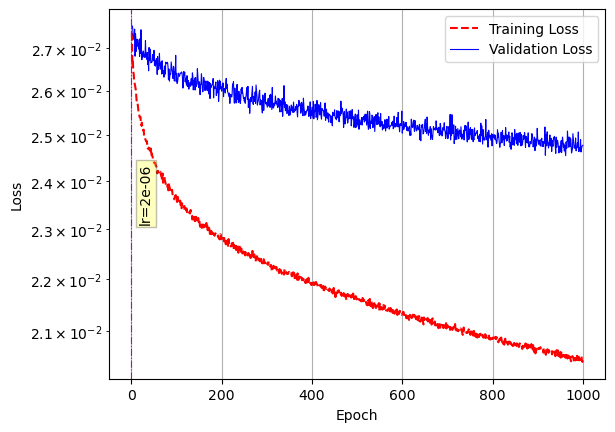

<Figure size 640x480 with 0 Axes>

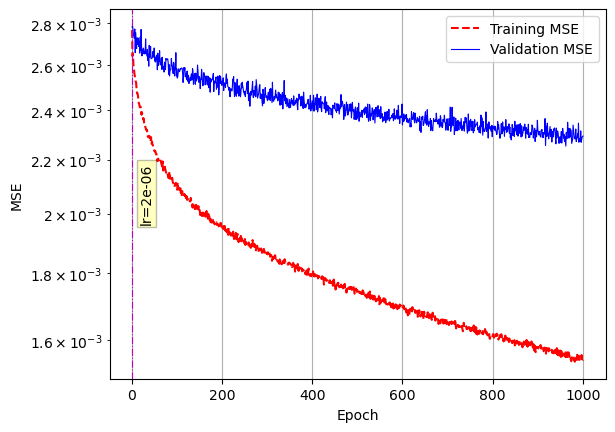

<Figure size 640x480 with 0 Axes>

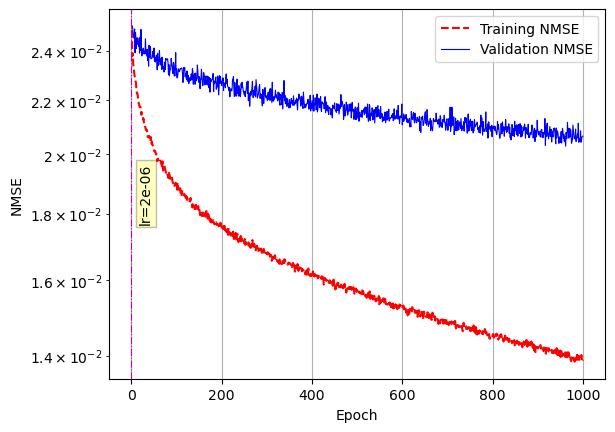

<Figure size 640x480 with 0 Axes>

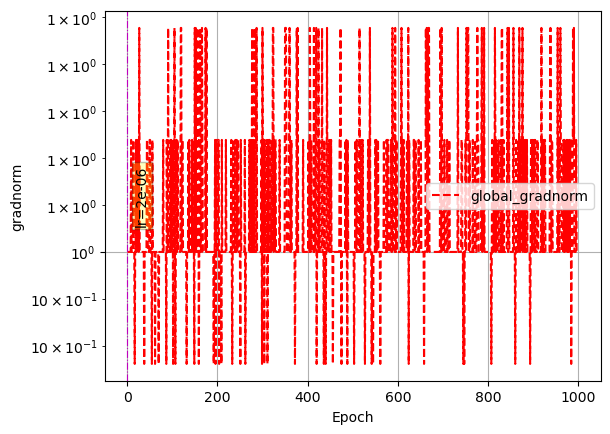

<Figure size 640x480 with 0 Axes>

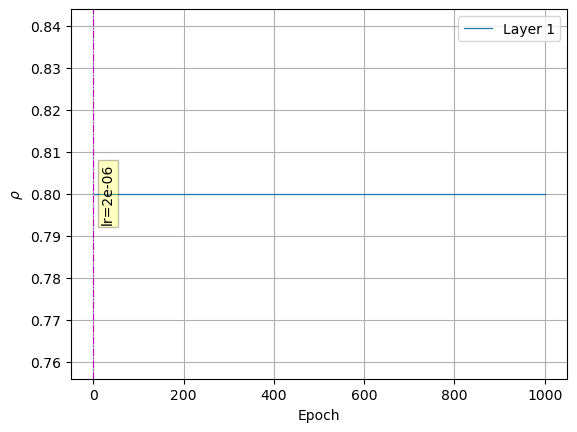

<Figure size 640x480 with 0 Axes>

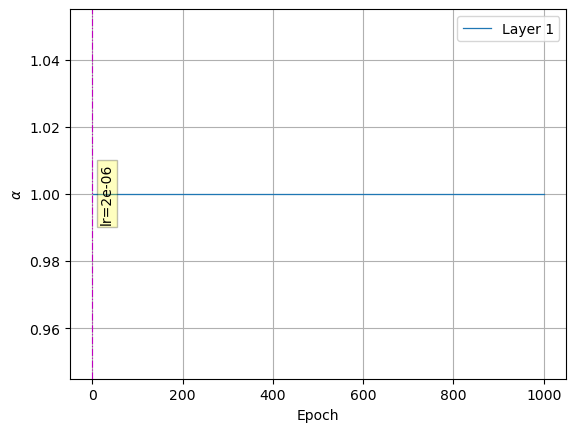

<Figure size 640x480 with 0 Axes>

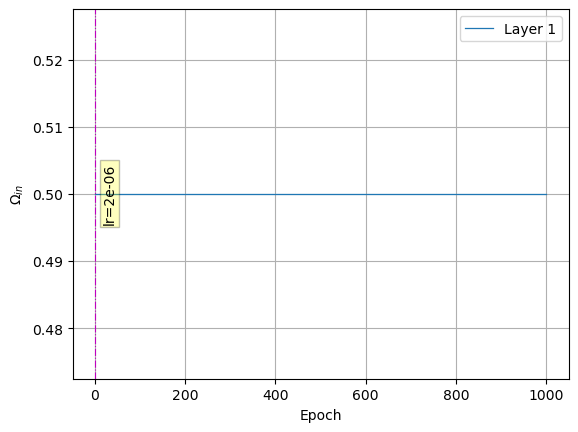



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.0
ListWrapper([False])
ListWrapper([False])
ListWrapper([False])


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0408 - mse: 0.0069 - NMSE: 0.0621 - covmat_fro_loss: 0.0033 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 1m 2.8s

Epoch 1: val_NMSE improved from inf to 0.07564, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-50_

Epoch 10/1000
49/49 [==============================] - ETA: 0s - loss: 0.0383 - mse: 0.0063 - NMSE: 0.0564 - covmat_fro_loss: 0.0032 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 2m 42.5s

Epoch 10: val_NMSE improved from 0.07508 to 0.07467, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0383 - mse: 0.0063 - NMSE: 0.0564 - covmat_fro_loss: 0.0032 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0469 - val_mse: 0.0083 - val_NMSE: 0.0747 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 11/1000
49/49 [========

49/49 [==============================] - ETA: 0s - loss: 0.0373 - mse: 0.0060 - NMSE: 0.0542 - covmat_fro_loss: 0.0032 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 4m 22.6s

Epoch 19: val_NMSE did not improve from 0.07387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0373 - mse: 0.0060 - NMSE: 0.0542 - covmat_fro_loss: 0.0032 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0471 - val_mse: 0.0083 - val_NMSE: 0.0751 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 20/1000
49/49 [==============================] - ETA: 0s - loss: 0.0374 - mse: 0.0060 - NMSE: 0.0544 - covmat_fro_loss: 0.0032 - global_gradnorm: 1.0000 - rho_res_0

Epoch 29/1000
49/49 [==============================] - ETA: 0s - loss: 0.0369 - mse: 0.0059 - NMSE: 0.0532 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 6m 13.4s

Epoch 29: val_NMSE improved from 0.07352 to 0.07333, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 230ms/step - loss: 0.0369 - mse: 0.0059 - NMSE: 0.0532 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0463 - val_mse: 0.0081 - val_NMSE: 0.0733 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 30/1000
49/49 [========

49/49 [==============================] - ETA: 0s - loss: 0.0364 - mse: 0.0058 - NMSE: 0.0522 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 7m 53.9s

Epoch 38: val_NMSE did not improve from 0.07272
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0364 - mse: 0.0058 - NMSE: 0.0522 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0467 - val_mse: 0.0082 - val_NMSE: 0.0740 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 39/1000
49/49 [==============================] - ETA: 0s - loss: 0.0361 - mse: 0.0057 - NMSE: 0.0515 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0

Epoch 48/1000
49/49 [==============================] - ETA: 0s - loss: 0.0360 - mse: 0.0057 - NMSE: 0.0512 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 9m 45.8s

Epoch 48: val_NMSE improved from 0.07248 to 0.07203, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 12s 236ms/step - loss: 0.0360 - mse: 0.0057 - NMSE: 0.0512 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0458 - val_mse: 0.0080 - val_NMSE: 0.0720 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 49/1000
49/49 [========

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 234ms/step - loss: 0.0358 - mse: 0.0057 - NMSE: 0.0509 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0456 - val_mse: 0.0080 - val_NMSE: 0.0719 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 58/1000
49/49 [==============================] - ETA: 0s - loss: 0.0358 - mse: 0.0057 - NMSE: 0.0509 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 11m 38.8s

Epoch 58: val_NMSE did not improve from 0.07187
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [=

Epoch 67/1000
49/49 [==============================] - ETA: 0s - loss: 0.0352 - mse: 0.0055 - NMSE: 0.0495 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 13m 19.7s

Epoch 67: val_NMSE did not improve from 0.07181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0352 - mse: 0.0055 - NMSE: 0.0495 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0457 - val_mse: 0.0080 - val_NMSE: 0.0719 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 68/1000
49/49 [==============================] - ETA: 0s - loss: 0.0354 - mse: 0.0055 - NMSE: 0.0499 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0

Epoch 77/1000
49/49 [==============================] - ETA: 0s - loss: 0.0351 - mse: 0.0055 - NMSE: 0.0492 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 15m 10.8s

Epoch 77: val_NMSE did not improve from 0.07141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0351 - mse: 0.0055 - NMSE: 0.0492 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0460 - val_mse: 0.0081 - val_NMSE: 0.0726 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 78/1000
49/49 [==============================] - ETA: 0s - loss: 0.0350 - mse: 0.0054 - NMSE: 0.0490 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.0

Epoch 87/1000
49/49 [==============================] - ETA: 0s - loss: 0.0349 - mse: 0.0054 - NMSE: 0.0487 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 17m 2.7s

Epoch 87: val_NMSE did not improve from 0.07080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0349 - mse: 0.0054 - NMSE: 0.0487 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0456 - val_mse: 0.0080 - val_NMSE: 0.0716 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 88/1000
49/49 [==============================] - ETA: 0s - loss: 0.0348 - mse: 0.0054 - NMSE: 0.0485 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.00

Epoch 97/1000
49/49 [==============================] - ETA: 0s - loss: 0.0347 - mse: 0.0054 - NMSE: 0.0483 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 18m 53.9s

Epoch 97: val_NMSE did not improve from 0.07080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0347 - mse: 0.0054 - NMSE: 0.0483 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0456 - val_mse: 0.0080 - val_NMSE: 0.0716 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 98/1000
49/49 [==============================] - ETA: 0s - loss: 0.0345 - mse: 0.0053 - NMSE: 0.0480 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0

Epoch 107/1000
49/49 [==============================] - ETA: 0s - loss: 0.0344 - mse: 0.0053 - NMSE: 0.0478 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 20m 45.8s

Epoch 107: val_NMSE did not improve from 0.07080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0344 - mse: 0.0053 - NMSE: 0.0478 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0453 - val_mse: 0.0079 - val_NMSE: 0.0710 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 108/1000
49/49 [==============================] - ETA: 0s - loss: 0.0342 - mse: 0.0052 - NMSE: 0.0472 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 117/1000
49/49 [==============================] - ETA: 0s - loss: 0.0342 - mse: 0.0052 - NMSE: 0.0472 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 22m 37.6s

Epoch 117: val_NMSE did not improve from 0.07071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0342 - mse: 0.0052 - NMSE: 0.0472 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0453 - val_mse: 0.0079 - val_NMSE: 0.0711 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 118/1000
49/49 [==============================] - ETA: 0s - loss: 0.0342 - mse: 0.0052 - NMSE: 0.0471 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 127/1000
49/49 [==============================] - ETA: 0s - loss: 0.0339 - mse: 0.0052 - NMSE: 0.0465 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 24m 27.5s

Epoch 127: val_NMSE did not improve from 0.07035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0339 - mse: 0.0052 - NMSE: 0.0465 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0452 - val_mse: 0.0079 - val_NMSE: 0.0708 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 128/1000
49/49 [==============================] - ETA: 0s - loss: 0.0341 - mse: 0.0052 - NMSE: 0.0469 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 137/1000
49/49 [==============================] - ETA: 0s - loss: 0.0340 - mse: 0.0052 - NMSE: 0.0467 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 26m 18.6s

Epoch 137: val_NMSE did not improve from 0.07035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0340 - mse: 0.0052 - NMSE: 0.0467 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0451 - val_mse: 0.0078 - val_NMSE: 0.0706 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 138/1000
49/49 [==============================] - ETA: 0s - loss: 0.0338 - mse: 0.0051 - NMSE: 0.0463 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 147/1000
49/49 [==============================] - ETA: 0s - loss: 0.0335 - mse: 0.0051 - NMSE: 0.0458 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 28m 9.9s

Epoch 147: val_NMSE did not improve from 0.07035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0335 - mse: 0.0051 - NMSE: 0.0458 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0453 - val_mse: 0.0079 - val_NMSE: 0.0711 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 148/1000
49/49 [==============================] - ETA: 0s - loss: 0.0338 - mse: 0.0051 - NMSE: 0.0463 - covmat_fro_loss: 0.0030 - global_gradnorm: 1

Epoch 157/1000
49/49 [==============================] - ETA: 0s - loss: 0.0335 - mse: 0.0051 - NMSE: 0.0455 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 30m 1.5s

Epoch 157: val_NMSE did not improve from 0.06981
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0335 - mse: 0.0051 - NMSE: 0.0455 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0450 - val_mse: 0.0078 - val_NMSE: 0.0705 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 158/1000
49/49 [==============================] - ETA: 0s - loss: 0.0335 - mse: 0.0051 - NMSE: 0.0457 - covmat_fro_loss: 0.0030 - global_gradnorm: 1

Epoch 167/1000
49/49 [==============================] - ETA: 0s - loss: 0.0334 - mse: 0.0050 - NMSE: 0.0454 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 31m 52.9s

Epoch 167: val_NMSE did not improve from 0.06981
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 229ms/step - loss: 0.0334 - mse: 0.0050 - NMSE: 0.0454 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0448 - val_mse: 0.0078 - val_NMSE: 0.0700 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 168/1000
49/49 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0051 - NMSE: 0.0458 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 177/1000
49/49 [==============================] - ETA: 0s - loss: 0.0332 - mse: 0.0050 - NMSE: 0.0449 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 33m 43.9s

Epoch 177: val_NMSE did not improve from 0.06981
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 227ms/step - loss: 0.0332 - mse: 0.0050 - NMSE: 0.0449 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0452 - val_mse: 0.0079 - val_NMSE: 0.0709 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 178/1000
49/49 [==============================] - ETA: 0s - loss: 0.0334 - mse: 0.0050 - NMSE: 0.0453 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 187/1000
49/49 [==============================] - ETA: 0s - loss: 0.0331 - mse: 0.0050 - NMSE: 0.0448 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 35m 35.5s

Epoch 187: val_NMSE did not improve from 0.06944
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0331 - mse: 0.0050 - NMSE: 0.0448 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0454 - val_mse: 0.0079 - val_NMSE: 0.0713 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 188/1000
49/49 [==============================] - ETA: 0s - loss: 0.0332 - mse: 0.0050 - NMSE: 0.0449 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 197/1000
49/49 [==============================] - ETA: 0s - loss: 0.0329 - mse: 0.0049 - NMSE: 0.0444 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 37m 26.8s

Epoch 197: val_NMSE did not improve from 0.06910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0329 - mse: 0.0049 - NMSE: 0.0444 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0447 - val_mse: 0.0077 - val_NMSE: 0.0697 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 198/1000
49/49 [==============================] - ETA: 0s - loss: 0.0330 - mse: 0.0049 - NMSE: 0.0445 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 207/1000
49/49 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0049 - NMSE: 0.0442 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 39m 18.5s

Epoch 207: val_NMSE did not improve from 0.06910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 231ms/step - loss: 0.0328 - mse: 0.0049 - NMSE: 0.0442 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0449 - val_mse: 0.0078 - val_NMSE: 0.0703 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 208/1000
49/49 [==============================] - ETA: 0s - loss: 0.0330 - mse: 0.0049 - NMSE: 0.0445 - covmat_fro_loss: 0.0030 - global_gradnorm: 

Epoch 217/1000
49/49 [==============================] - ETA: 0s - loss: 0.0328 - mse: 0.0049 - NMSE: 0.0440 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 41m 9.4s

Epoch 217: val_NMSE did not improve from 0.06910
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0328 - mse: 0.0049 - NMSE: 0.0440 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0449 - val_mse: 0.0078 - val_NMSE: 0.0702 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 218/1000
49/49 [==============================] - ETA: 0s - loss: 0.0330 - mse: 0.0049 - NMSE: 0.0444 - covmat_fro_loss: 0.0030 - global_gradnorm: 1

Epoch 227/1000
49/49 [==============================] - ETA: 0s - loss: 0.0327 - mse: 0.0049 - NMSE: 0.0438 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 43m 0.9s

Epoch 227: val_NMSE did not improve from 0.06902
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 229ms/step - loss: 0.0327 - mse: 0.0049 - NMSE: 0.0438 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0446 - val_mse: 0.0077 - val_NMSE: 0.0694 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 228/1000
49/49 [==============================] - ETA: 0s - loss: 0.0326 - mse: 0.0048 - NMSE: 0.0435 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 237/1000
49/49 [==============================] - ETA: 0s - loss: 0.0326 - mse: 0.0048 - NMSE: 0.0436 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 44m 51.8s

Epoch 237: val_NMSE did not improve from 0.06870
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0326 - mse: 0.0048 - NMSE: 0.0436 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0448 - val_mse: 0.0078 - val_NMSE: 0.0698 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 238/1000
49/49 [==============================] - ETA: 0s - loss: 0.0326 - mse: 0.0048 - NMSE: 0.0436 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 247/1000
49/49 [==============================] - ETA: 0s - loss: 0.0324 - mse: 0.0048 - NMSE: 0.0432 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 46m 42.4s

Epoch 247: val_NMSE did not improve from 0.06870
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 227ms/step - loss: 0.0324 - mse: 0.0048 - NMSE: 0.0432 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0446 - val_mse: 0.0077 - val_NMSE: 0.0695 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 248/1000
49/49 [==============================] - ETA: 0s - loss: 0.0323 - mse: 0.0048 - NMSE: 0.0430 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 257/1000
49/49 [==============================] - ETA: 0s - loss: 0.0324 - mse: 0.0048 - NMSE: 0.0431 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 48m 32.6s

Epoch 257: val_NMSE did not improve from 0.06870
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 224ms/step - loss: 0.0324 - mse: 0.0048 - NMSE: 0.0431 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0444 - val_mse: 0.0077 - val_NMSE: 0.0692 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 258/1000
49/49 [==============================] - ETA: 0s - loss: 0.0324 - mse: 0.0048 - NMSE: 0.0431 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 267/1000
49/49 [==============================] - ETA: 0s - loss: 0.0322 - mse: 0.0048 - NMSE: 0.0429 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 50m 23.3s

Epoch 267: val_NMSE did not improve from 0.06870
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 225ms/step - loss: 0.0322 - mse: 0.0048 - NMSE: 0.0429 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0448 - val_mse: 0.0078 - val_NMSE: 0.0700 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 268/1000
49/49 [==============================] - ETA: 0s - loss: 0.0323 - mse: 0.0048 - NMSE: 0.0430 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 277/1000
49/49 [==============================] - ETA: 0s - loss: 0.0323 - mse: 0.0048 - NMSE: 0.0430 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 52m 13.7s

Epoch 277: val_NMSE did not improve from 0.06870
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 229ms/step - loss: 0.0323 - mse: 0.0048 - NMSE: 0.0430 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0448 - val_mse: 0.0078 - val_NMSE: 0.0699 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 278/1000
49/49 [==============================] - ETA: 0s - loss: 0.0323 - mse: 0.0048 - NMSE: 0.0429 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 287/1000
49/49 [==============================] - ETA: 0s - loss: 0.0322 - mse: 0.0047 - NMSE: 0.0426 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 54m 4.9s

Epoch 287: val_NMSE did not improve from 0.06840
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0322 - mse: 0.0047 - NMSE: 0.0426 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0446 - val_mse: 0.0077 - val_NMSE: 0.0695 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 288/1000
49/49 [==============================] - ETA: 0s - loss: 0.0321 - mse: 0.0047 - NMSE: 0.0424 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 297/1000
49/49 [==============================] - ETA: 0s - loss: 0.0320 - mse: 0.0047 - NMSE: 0.0423 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 55m 55.8s

Epoch 297: val_NMSE did not improve from 0.06810
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 228ms/step - loss: 0.0320 - mse: 0.0047 - NMSE: 0.0423 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0440 - val_mse: 0.0076 - val_NMSE: 0.0682 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 298/1000
49/49 [==============================] - ETA: 0s - loss: 0.0319 - mse: 0.0047 - NMSE: 0.0421 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 307/1000
49/49 [==============================] - ETA: 0s - loss: 0.0319 - mse: 0.0047 - NMSE: 0.0420 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 57m 46.7s

Epoch 307: val_NMSE did not improve from 0.06780
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 222ms/step - loss: 0.0319 - mse: 0.0047 - NMSE: 0.0420 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0446 - val_mse: 0.0077 - val_NMSE: 0.0694 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 308/1000
49/49 [==============================] - ETA: 0s - loss: 0.0319 - mse: 0.0047 - NMSE: 0.0422 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 317/1000
49/49 [==============================] - ETA: 0s - loss: 0.0317 - mse: 0.0046 - NMSE: 0.0417 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 0h 59m 37.8s

Epoch 317: val_NMSE did not improve from 0.06780
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0317 - mse: 0.0046 - NMSE: 0.0417 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0444 - val_mse: 0.0077 - val_NMSE: 0.0690 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 318/1000
49/49 [==============================] - ETA: 0s - loss: 0.0318 - mse: 0.0046 - NMSE: 0.0417 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 327/1000
49/49 [==============================] - ETA: 0s - loss: 0.0318 - mse: 0.0046 - NMSE: 0.0418 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 1m 26.9s

Epoch 327: val_NMSE did not improve from 0.06780
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 223ms/step - loss: 0.0318 - mse: 0.0046 - NMSE: 0.0418 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0443 - val_mse: 0.0077 - val_NMSE: 0.0689 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 328/1000
49/49 [==============================] - ETA: 0s - loss: 0.0318 - mse: 0.0046 - NMSE: 0.0417 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 337/1000
49/49 [==============================] - ETA: 0s - loss: 0.0317 - mse: 0.0046 - NMSE: 0.0417 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 3m 15.6s

Epoch 337: val_NMSE did not improve from 0.06780
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 219ms/step - loss: 0.0317 - mse: 0.0046 - NMSE: 0.0417 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0443 - val_mse: 0.0076 - val_NMSE: 0.0688 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 338/1000
49/49 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0046 - NMSE: 0.0414 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 347/1000
49/49 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0046 - NMSE: 0.0413 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 5m 3.7s

Epoch 347: val_NMSE did not improve from 0.06777
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0316 - mse: 0.0046 - NMSE: 0.0413 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0445 - val_mse: 0.0077 - val_NMSE: 0.0693 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 348/1000
49/49 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0046 - NMSE: 0.0415 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.

Epoch 357/1000
49/49 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0046 - NMSE: 0.0415 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 6m 51.8s

Epoch 357: val_NMSE did not improve from 0.06777
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 217ms/step - loss: 0.0316 - mse: 0.0046 - NMSE: 0.0415 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0445 - val_mse: 0.0077 - val_NMSE: 0.0693 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 358/1000
49/49 [==============================] - ETA: 0s - loss: 0.0315 - mse: 0.0046 - NMSE: 0.0411 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 367/1000
49/49 [==============================] - ETA: 0s - loss: 0.0315 - mse: 0.0046 - NMSE: 0.0412 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 8m 39.9s

Epoch 367: val_NMSE did not improve from 0.06777
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 12s 246ms/step - loss: 0.0315 - mse: 0.0046 - NMSE: 0.0412 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0686 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 368/1000
49/49 [==============================] - ETA: 0s - loss: 0.0315 - mse: 0.0046 - NMSE: 0.0412 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 377/1000
49/49 [==============================] - ETA: 0s - loss: 0.0315 - mse: 0.0046 - NMSE: 0.0411 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 10m 28.1s

Epoch 377: val_NMSE did not improve from 0.06763
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 219ms/step - loss: 0.0315 - mse: 0.0046 - NMSE: 0.0411 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0686 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 378/1000
49/49 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0045 - NMSE: 0.0409 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 387/1000
49/49 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0046 - NMSE: 0.0410 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 12m 16.4s

Epoch 387: val_NMSE did not improve from 0.06763
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0314 - mse: 0.0046 - NMSE: 0.0410 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0439 - val_mse: 0.0075 - val_NMSE: 0.0679 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 388/1000
49/49 [==============================] - ETA: 0s - loss: 0.0313 - mse: 0.0045 - NMSE: 0.0408 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 397/1000
49/49 [==============================] - ETA: 0s - loss: 0.0313 - mse: 0.0045 - NMSE: 0.0407 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 14m 4.6s

Epoch 397: val_NMSE did not improve from 0.06721
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 226ms/step - loss: 0.0313 - mse: 0.0045 - NMSE: 0.0407 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0686 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 398/1000
49/49 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 407/1000
49/49 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0046 - NMSE: 0.0410 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 15m 52.6s

Epoch 407: val_NMSE did not improve from 0.06721
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0314 - mse: 0.0046 - NMSE: 0.0410 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0686 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 408/1000
49/49 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0045 - NMSE: 0.0405 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 417/1000
49/49 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0045 - NMSE: 0.0405 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 17m 40.6s

Epoch 417: val_NMSE did not improve from 0.06721
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 220ms/step - loss: 0.0312 - mse: 0.0045 - NMSE: 0.0405 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0687 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 418/1000
49/49 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0045 - NMSE: 0.0405 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 427/1000
49/49 [==============================] - ETA: 0s - loss: 0.0311 - mse: 0.0045 - NMSE: 0.0402 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 19m 30.5s

Epoch 427: val_NMSE did not improve from 0.06721
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 220ms/step - loss: 0.0311 - mse: 0.0045 - NMSE: 0.0402 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0685 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 428/1000
49/49 [==============================] - ETA: 0s - loss: 0.0313 - mse: 0.0045 - NMSE: 0.0408 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 437/1000
49/49 [==============================] - ETA: 0s - loss: 0.0310 - mse: 0.0044 - NMSE: 0.0400 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 21m 19.0s

Epoch 437: val_NMSE did not improve from 0.06721
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 219ms/step - loss: 0.0310 - mse: 0.0044 - NMSE: 0.0400 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0441 - val_mse: 0.0076 - val_NMSE: 0.0684 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 438/1000
49/49 [==============================] - ETA: 0s - loss: 0.0311 - mse: 0.0045 - NMSE: 0.0403 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 447/1000
49/49 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0399 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 23m 6.2s

Epoch 447: val_NMSE did not improve from 0.06721
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 216ms/step - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0399 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0443 - val_mse: 0.0076 - val_NMSE: 0.0688 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 448/1000
49/49 [==============================] - ETA: 0s - loss: 0.0310 - mse: 0.0045 - NMSE: 0.0401 - covmat_fro_loss: 0.0029 - global_gradnorm: 1

Epoch 457/1000
49/49 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0397 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 24m 53.3s

Epoch 457: val_NMSE did not improve from 0.06721
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 218ms/step - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0397 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0439 - val_mse: 0.0076 - val_NMSE: 0.0680 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 458/1000
49/49 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0399 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 467/1000
49/49 [==============================] - ETA: 0s - loss: 0.0310 - mse: 0.0044 - NMSE: 0.0400 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 26m 40.6s

Epoch 467: val_NMSE did not improve from 0.06706
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 214ms/step - loss: 0.0310 - mse: 0.0044 - NMSE: 0.0400 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0686 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 468/1000
49/49 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0044 - NMSE: 0.0397 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 477/1000
49/49 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 28m 27.9s

Epoch 477: val_NMSE did not improve from 0.06706
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 221ms/step - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0440 - val_mse: 0.0076 - val_NMSE: 0.0683 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 478/1000
49/49 [==============================] - ETA: 0s - loss: 0.0310 - mse: 0.0044 - NMSE: 0.0400 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 487/1000
49/49 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0397 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 30m 14.9s

Epoch 487: val_NMSE did not improve from 0.06706
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 11s 216ms/step - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0397 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0442 - val_mse: 0.0076 - val_NMSE: 0.0686 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 488/1000
49/49 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0044 - NMSE: 0.0396 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 497/1000
49/49 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0399 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 32m 5.0s

Epoch 497: val_NMSE did not improve from 0.06706
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 13s 265ms/step - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0399 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0439 - val_mse: 0.0075 - val_NMSE: 0.0679 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 498/1000
49/49 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0044 - NMSE: 0.0394 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 507/1000
49/49 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0044 - NMSE: 0.0393 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 33m 45.8s

Epoch 507: val_NMSE did not improve from 0.06706
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0307 - mse: 0.0044 - NMSE: 0.0393 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0438 - val_mse: 0.0075 - val_NMSE: 0.0676 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 508/1000
49/49 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0044 - NMSE: 0.0395 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 517/1000
49/49 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0043 - NMSE: 0.0391 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 35m 27.1s

Epoch 517: val_NMSE did not improve from 0.06696
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 205ms/step - loss: 0.0306 - mse: 0.0043 - NMSE: 0.0391 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0438 - val_mse: 0.0075 - val_NMSE: 0.0677 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 518/1000
49/49 [==============================] - ETA: 0s - loss: 0.0307 - mse: 0.0044 - NMSE: 0.0394 - covmat_fro_loss: 0.0029 - global_gradnorm: 

Epoch 527/1000
49/49 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0044 - NMSE: 0.0396 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 37m 8.9s

Epoch 527: val_NMSE did not improve from 0.06696
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 208ms/step - loss: 0.0308 - mse: 0.0044 - NMSE: 0.0396 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0436 - val_mse: 0.0075 - val_NMSE: 0.0672 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 528/1000
49/49 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 537/1000
49/49 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 38m 50.1s

Epoch 537: val_NMSE did not improve from 0.06696
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0306 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0438 - val_mse: 0.0075 - val_NMSE: 0.0677 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 538/1000
49/49 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0390 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 547/1000
49/49 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 40m 31.1s

Epoch 547: val_NMSE did not improve from 0.06684
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 205ms/step - loss: 0.0306 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0440 - val_mse: 0.0076 - val_NMSE: 0.0680 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 548/1000
49/49 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0043 - NMSE: 0.0391 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 557/1000
49/49 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0389 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 42m 11.8s

Epoch 557: val_NMSE did not improve from 0.06684
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0389 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0444 - val_mse: 0.0077 - val_NMSE: 0.0691 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 558/1000
49/49 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0044 - NMSE: 0.0392 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 567/1000
49/49 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0388 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 43m 52.6s

Epoch 567: val_NMSE did not improve from 0.06684
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0388 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0435 - val_mse: 0.0075 - val_NMSE: 0.0671 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 568/1000
49/49 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0388 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 577/1000
49/49 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0389 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 45m 33.8s

Epoch 577: val_NMSE did not improve from 0.06662
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 204ms/step - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0389 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0436 - val_mse: 0.0075 - val_NMSE: 0.0672 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 578/1000
49/49 [==============================] - ETA: 0s - loss: 0.0304 - mse: 0.0043 - NMSE: 0.0388 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 587/1000
49/49 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0390 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 47m 15.0s

Epoch 587: val_NMSE did not improve from 0.06662
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0305 - mse: 0.0043 - NMSE: 0.0390 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0437 - val_mse: 0.0075 - val_NMSE: 0.0674 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 588/1000
49/49 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0043 - NMSE: 0.0385 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 597/1000
49/49 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0043 - NMSE: 0.0385 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 48m 55.8s

Epoch 597: val_NMSE did not improve from 0.06662
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 205ms/step - loss: 0.0303 - mse: 0.0043 - NMSE: 0.0385 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0439 - val_mse: 0.0075 - val_NMSE: 0.0679 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 598/1000
49/49 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0043 - NMSE: 0.0386 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 607/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0380 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 50m 35.9s

Epoch 607: val_NMSE did not improve from 0.06662
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 204ms/step - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0380 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0437 - val_mse: 0.0075 - val_NMSE: 0.0675 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 608/1000
49/49 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0043 - NMSE: 0.0385 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 617/1000
49/49 [==============================] - ETA: 0s - loss: 0.0302 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 52m 17.4s

Epoch 617: val_NMSE did not improve from 0.06662
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 210ms/step - loss: 0.0302 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0437 - val_mse: 0.0075 - val_NMSE: 0.0675 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 618/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 627/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 53m 59.4s

Epoch 627: val_NMSE did not improve from 0.06662
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0438 - val_mse: 0.0075 - val_NMSE: 0.0678 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 628/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0380 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 637/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 55m 41.7s

Epoch 637: val_NMSE did not improve from 0.06616
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0438 - val_mse: 0.0075 - val_NMSE: 0.0677 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 638/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 647/1000
49/49 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 57m 23.3s

Epoch 647: val_NMSE did not improve from 0.06616
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0433 - val_mse: 0.0074 - val_NMSE: 0.0666 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 648/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0380 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 657/1000
49/49 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 1h 59m 5.4s

Epoch 657: val_NMSE did not improve from 0.06616
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 208ms/step - loss: 0.0301 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0439 - val_mse: 0.0076 - val_NMSE: 0.0680 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 658/1000
49/49 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0378 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 667/1000
49/49 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 0m 47.3s

Epoch 667: val_NMSE did not improve from 0.06616
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0433 - val_mse: 0.0074 - val_NMSE: 0.0666 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 668/1000
49/49 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0377 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 677/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 2m 28.3s

Epoch 677: val_NMSE did not improve from 0.06616
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 205ms/step - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0436 - val_mse: 0.0075 - val_NMSE: 0.0672 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 678/1000
49/49 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 687/1000
49/49 [==============================] - ETA: 0s - loss: 0.0299 - mse: 0.0042 - NMSE: 0.0376 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 4m 9.3s

Epoch 687: val_NMSE did not improve from 0.06607
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0299 - mse: 0.0042 - NMSE: 0.0376 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0438 - val_mse: 0.0075 - val_NMSE: 0.0676 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 688/1000
49/49 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0378 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.

Epoch 697/1000
49/49 [==============================] - ETA: 0s - loss: 0.0299 - mse: 0.0042 - NMSE: 0.0376 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 5m 50.3s

Epoch 697: val_NMSE did not improve from 0.06607
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 204ms/step - loss: 0.0299 - mse: 0.0042 - NMSE: 0.0376 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0433 - val_mse: 0.0074 - val_NMSE: 0.0666 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 698/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 707/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 7m 31.0s

Epoch 707: val_NMSE did not improve from 0.06607
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 208ms/step - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0434 - val_mse: 0.0074 - val_NMSE: 0.0668 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 708/1000
49/49 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0042 - NMSE: 0.0378 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 717/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 9m 12.1s

Epoch 717: val_NMSE did not improve from 0.06607
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 208ms/step - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0431 - val_mse: 0.0074 - val_NMSE: 0.0662 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 718/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 727/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 10m 53.3s

Epoch 727: val_NMSE did not improve from 0.06607
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0298 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0432 - val_mse: 0.0074 - val_NMSE: 0.0663 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 728/1000
49/49 [==============================] - ETA: 0s - loss: 0.0299 - mse: 0.0042 - NMSE: 0.0375 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 737/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 12m 34.6s

Epoch 737: val_NMSE improved from 0.06607 to 0.06597, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 212ms/step - loss: 0.0298 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0430 - val_mse: 0.0073 - val_NMSE: 0.0660 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 738/1000
49/49 [====

Epoch 747/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 14m 15.6s

Epoch 747: val_NMSE did not improve from 0.06597
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 204ms/step - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0374 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0430 - val_mse: 0.0073 - val_NMSE: 0.0660 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 748/1000
49/49 [==============================] - ETA: 0s - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0369 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 757/1000
49/49 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 15m 56.7s

Epoch 757: val_NMSE did not improve from 0.06584
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0298 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0437 - val_mse: 0.0075 - val_NMSE: 0.0675 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 758/1000
49/49 [==============================] - ETA: 0s - loss: 0.0297 - mse: 0.0041 - NMSE: 0.0371 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 767/1000
49/49 [==============================] - ETA: 0s - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0369 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 17m 37.7s

Epoch 767: val_NMSE did not improve from 0.06584
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0369 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0434 - val_mse: 0.0074 - val_NMSE: 0.0669 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 768/1000
49/49 [==============================] - ETA: 0s - loss: 0.0297 - mse: 0.0041 - NMSE: 0.0372 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 777/1000
49/49 [==============================] - ETA: 0s - loss: 0.0297 - mse: 0.0041 - NMSE: 0.0372 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 19m 18.9s

Epoch 777: val_NMSE did not improve from 0.06584
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 208ms/step - loss: 0.0297 - mse: 0.0041 - NMSE: 0.0372 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0438 - val_mse: 0.0075 - val_NMSE: 0.0677 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 778/1000
49/49 [==============================] - ETA: 0s - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0369 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 787/1000
49/49 [==============================] - ETA: 0s - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0369 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 21m 0.1s

Epoch 787: val_NMSE did not improve from 0.06584
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 210ms/step - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0369 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0433 - val_mse: 0.0074 - val_NMSE: 0.0667 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 788/1000
49/49 [==============================] - ETA: 0s - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0370 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 797/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0368 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 22m 41.2s

Epoch 797: val_NMSE did not improve from 0.06584
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 205ms/step - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0368 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0431 - val_mse: 0.0074 - val_NMSE: 0.0663 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 798/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0368 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 807/1000
49/49 [==============================] - ETA: 0s - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0370 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 24m 22.1s

Epoch 807: val_NMSE did not improve from 0.06584
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0296 - mse: 0.0041 - NMSE: 0.0370 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0436 - val_mse: 0.0075 - val_NMSE: 0.0673 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 808/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0368 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 817/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0367 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 26m 2.9s

Epoch 817: val_NMSE did not improve from 0.06547
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 205ms/step - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0367 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0437 - val_mse: 0.0075 - val_NMSE: 0.0676 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 818/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0366 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 827/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0366 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 27m 44.0s

Epoch 827: val_NMSE did not improve from 0.06547
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 205ms/step - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0366 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0434 - val_mse: 0.0074 - val_NMSE: 0.0670 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 828/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0367 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 837/1000
49/49 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0041 - NMSE: 0.0366 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 29m 25.1s

Epoch 837: val_NMSE did not improve from 0.06547
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0294 - mse: 0.0041 - NMSE: 0.0366 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0436 - val_mse: 0.0075 - val_NMSE: 0.0674 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 838/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0368 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 847/1000
49/49 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0041 - NMSE: 0.0366 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 31m 6.5s

Epoch 847: val_NMSE did not improve from 0.06547
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0294 - mse: 0.0041 - NMSE: 0.0366 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0431 - val_mse: 0.0074 - val_NMSE: 0.0662 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 848/1000
49/49 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0041 - NMSE: 0.0367 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 857/1000
49/49 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0041 - NMSE: 0.0365 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 32m 47.5s

Epoch 857: val_NMSE did not improve from 0.06543
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0294 - mse: 0.0041 - NMSE: 0.0365 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0434 - val_mse: 0.0074 - val_NMSE: 0.0668 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 858/1000
49/49 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 867/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 34m 28.4s

Epoch 867: val_NMSE did not improve from 0.06543
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0436 - val_mse: 0.0075 - val_NMSE: 0.0673 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 868/1000
49/49 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 877/1000
49/49 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 36m 10.4s

Epoch 877: val_NMSE did not improve from 0.06538
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0439 - val_mse: 0.0076 - val_NMSE: 0.0680 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 878/1000
49/49 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0364 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 887/1000
49/49 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 37m 52.1s

Epoch 887: val_NMSE did not improve from 0.06538
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0431 - val_mse: 0.0074 - val_NMSE: 0.0663 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 888/1000
49/49 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0041 - NMSE: 0.0365 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 897/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0361 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 39m 34.6s

Epoch 897: val_NMSE did not improve from 0.06534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 208ms/step - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0361 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0430 - val_mse: 0.0073 - val_NMSE: 0.0660 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 898/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0361 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 907/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 41m 16.7s

Epoch 907: val_NMSE did not improve from 0.06534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0435 - val_mse: 0.0074 - val_NMSE: 0.0670 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 908/1000
49/49 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0358 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 917/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0360 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 42m 58.3s

Epoch 917: val_NMSE did not improve from 0.06534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 208ms/step - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0360 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0432 - val_mse: 0.0074 - val_NMSE: 0.0664 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 918/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0361 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 927/1000
49/49 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 44m 40.2s

Epoch 927: val_NMSE did not improve from 0.06534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0429 - val_mse: 0.0073 - val_NMSE: 0.0657 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 928/1000
49/49 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 937/1000
49/49 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0358 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 46m 22.1s

Epoch 937: val_NMSE did not improve from 0.06534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0358 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0429 - val_mse: 0.0073 - val_NMSE: 0.0658 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 938/1000
49/49 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0040 - NMSE: 0.0356 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 947/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0360 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 48m 3.8s

Epoch 947: val_NMSE did not improve from 0.06499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 207ms/step - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0360 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0434 - val_mse: 0.0074 - val_NMSE: 0.0667 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 948/1000
49/49 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0040 - NMSE: 0.0361 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 957/1000
49/49 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0040 - NMSE: 0.0357 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 49m 45.7s

Epoch 957: val_NMSE did not improve from 0.06499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0290 - mse: 0.0040 - NMSE: 0.0357 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0431 - val_mse: 0.0074 - val_NMSE: 0.0662 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 958/1000
49/49 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0359 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 967/1000
49/49 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0357 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 51m 27.7s

Epoch 967: val_NMSE did not improve from 0.06499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0357 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0430 - val_mse: 0.0073 - val_NMSE: 0.0659 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 968/1000
49/49 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0040 - NMSE: 0.0357 - covmat_fro_loss: 0.0027 - global_gradnorm: 

Epoch 977/1000
49/49 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0358 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 53m 9.8s

Epoch 977: val_NMSE did not improve from 0.06499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 211ms/step - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0358 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0428 - val_mse: 0.0073 - val_NMSE: 0.0655 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 978/1000
49/49 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0040 - NMSE: 0.0357 - covmat_fro_loss: 0.0028 - global_gradnorm: 1

Epoch 987/1000
49/49 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0040 - NMSE: 0.0356 - covmat_fro_loss: 0.0027 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 54m 51.9s

Epoch 987: val_NMSE did not improve from 0.06499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 209ms/step - loss: 0.0290 - mse: 0.0040 - NMSE: 0.0356 - covmat_fro_loss: 0.0027 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0430 - val_mse: 0.0073 - val_NMSE: 0.0660 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 988/1000
49/49 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0040 - NMSE: 0.0357 - covmat_fro_loss: 0.0028 - global_gradnorm: 

Epoch 997/1000
49/49 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0039 - NMSE: 0.0352 - covmat_fro_loss: 0.0027 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - tot_time: 2h 56m 33.6s

Epoch 997: val_NMSE did not improve from 0.06499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_016/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 10s 206ms/step - loss: 0.0288 - mse: 0.0039 - NMSE: 0.0352 - covmat_fro_loss: 0.0027 - global_gradnorm: 1.0000 - rho_res_0: 0.8000 - alpha_0: 1.0000 - omega_in_0: 0.5000 - val_loss: 0.0432 - val_mse: 0.0074 - val_NMSE: 0.0664 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 1.0000 - val_omega_in_0: 0.5000
Epoch 998/1000
49/49 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0039 - NMSE: 0.0354 - covmat_fro_loss: 0.0027 - global_gradnorm: 

<Figure size 640x480 with 0 Axes>

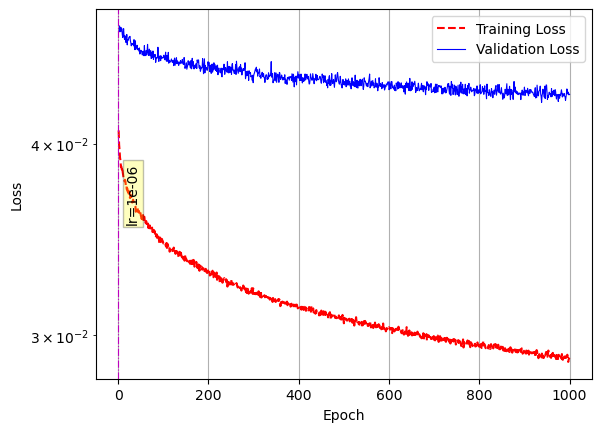

<Figure size 640x480 with 0 Axes>

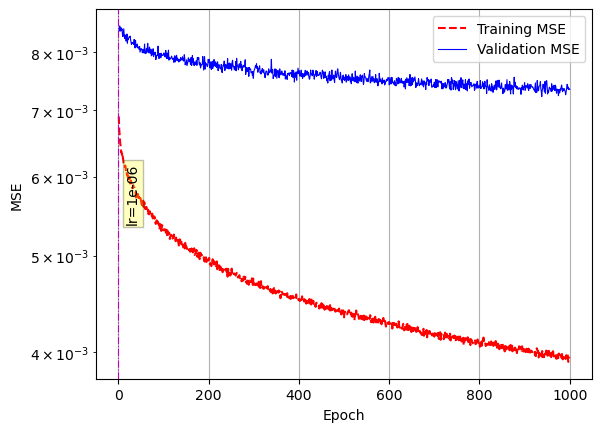

<Figure size 640x480 with 0 Axes>

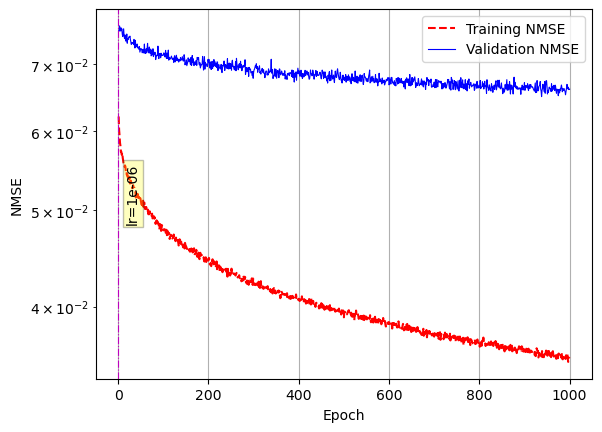

<Figure size 640x480 with 0 Axes>

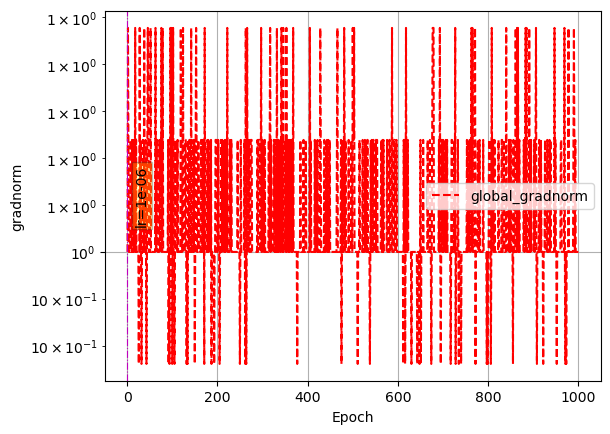

<Figure size 640x480 with 0 Axes>

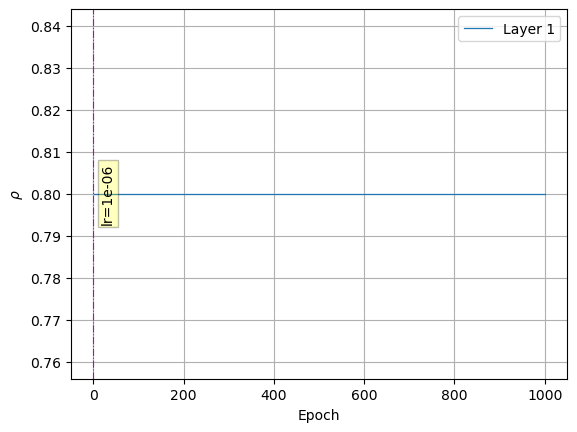

<Figure size 640x480 with 0 Axes>

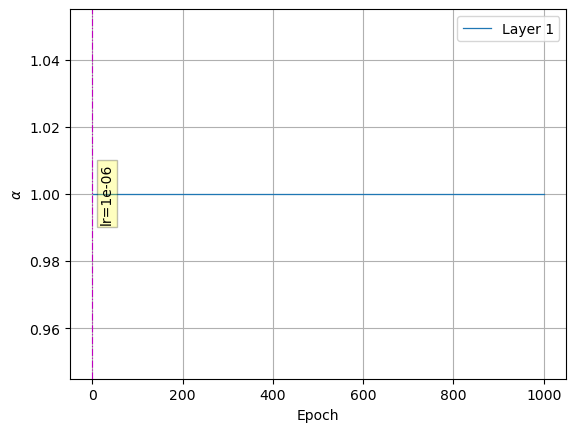

<Figure size 640x480 with 0 Axes>

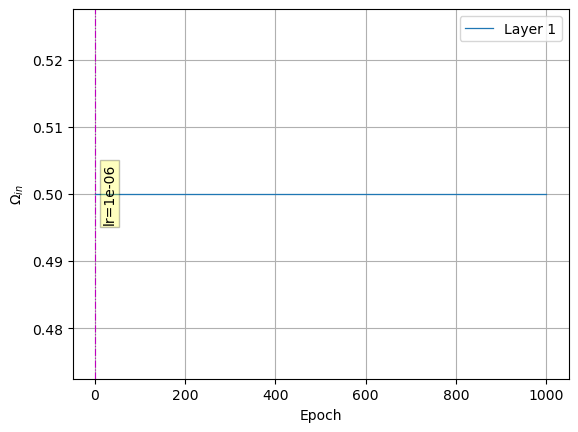

<Figure size 640x480 with 0 Axes>

In [22]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.25 * np.round(4*global_clipnorm)

In [23]:
### Training the combined AE-RNN


# 